<a href="https://colab.research.google.com/github/uu-sml/wasp-assigninmen-af-classification/blob/main/assignment_ecg_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WASP Course: Artificial Intelligence and Machine Learning

Lecturer: Dave Zachariah

Assignment responsible: Niklas Gunnarsson, Carl Andersson, Daniel Gedon

# Student and Group Information

Fill this out for the submission of the assignment (you submit this notebook with your solution)

- **Student names:** <font color='red'>Arturas Aleksandraus, Vilhelm Agdur</font>

- **Team ID:** <font color='red'>G49</font>

Make sure that the team id is the same as the one with which you submit your model predictions (see coding task 7) such that we can check your performance.

---
# Module 3 - Assignment Overview: ECG classification

The [electrocardiogram (ECG)](https://www.mayoclinic.org/tests-procedures/ekg/about/pac-20384983) records the electrical signals in the heart. It is a common  test used to quickly detect heart problems and to monitor the heart's health. 
In this assignment you will implement and evaluate a model to classify whether the person has [atrial fibrillation (AF)](https://www.mayoclinic.org/diseases-conditions/atrial-fibrillation/symptoms-causes/syc-20350624.) or not based on measurements from the ECG exam. 


**Submission:** You submit the deliverables (see below) at https://canvas.kth.se/courses/42324/assignments/254507

**Due Date:** August 25, 2023.

---
## Basic Tasks
Your task is to implement a classification model, train this model on training data, and evaluate its performance on validation data. We provide skeleton code for the implementation of a simple convolution neural network model.

The steps required to implement this model are presented as numbered tasks below. In total there are seven (7) coding tasks and five (5) explanation tasks. 

## Competitive setting

You have to compute the predictions for the test data (you do not have the labels for it) and submit your predictions to be evaluated to a leaderboard. These predictions will be scored and your submission will be ranked according to the F1 score and compared with your colleagues. In the end a winning team will be determined.

### Deliverables
There are two deliverables:
1. You have to submit this Jupyter notebook on the course web-page (Canvas) together with your code and explanations (where asked for it) that describe your implementation and your experimental results. The notebook should run as a standalone in google colab.
2. You have to have at least **three (3)** submissions (for instructions on how to submit, see coding task 7) where you try to improve the model architecture, the training procedure or the problem formulation. In the submission of this notebook you have to provide a short explanation of what changed between each submission and justify why you decided to make these changes.

### Grading
To pass the assignment, you must submit a complete and working implementation of a model and a well-motivated description and evaluation of it. Your model should reach an Area under the ROC curve (AUROC) on the test data of at least 0.97 and an Average Precision (AP) score of 0.95. Note that the leaderboard to is sorted by F1 score and not AUROC, hence you would want to balance all three metrics.

### GPU Acceleration
To be able to use the GPUs provided by colab in order to speed up your computations, you want to check that the `Hardware accelerator` is set to `GPU` under `Runtime > change runtime type`. Note that notebooks run by connecting to virtual machines that have maximum lifetimes that can be as much as 12 hours. Notebooks will also disconnect from VMs when left idle for too long. 

In [1]:
import os

# helper function
def exists(path):
    val = os.path.exists(path)
    if val:
        print(f'{path} already exits. Using cached. Delete it manually to recieve it again!')
    return val

# # clone requirements.txt if not yet available
# if not exists('requirements_base.txt'):
#      !wget https://raw.githubusercontent.com/Arty-Facts/wasp_al_and_ml_2023/main/environment/requirements_base.txt

In [2]:
# Install packages (python>=3.9 is required)
# !pip install -r requirements_base.txt

In [3]:
# Import
import torch
import torch.nn as nn
import numpy as np
from tqdm.notebook import trange, tqdm
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from sklearn.metrics import roc_auc_score
import torchvision.transforms as transforms

from functools import partial

import multiprocessing
try:
    multiprocessing.set_start_method('spawn')
except RuntimeError:
    pass
import glob, json
from pathlib import Path
import optuna


In [4]:
# from google.colab import output
# output.enable_custom_widget_manager()

%matplotlib widget
%load_ext autoreload
%autoreload 2

---
## The data set

The dataset is a subset of the [*CODE dataset*](https://scilifelab.figshare.com/articles/dataset/CODE_dataset/15169716): an anotated database of ECGs. The ECG exams were recorded in Brazil by the Telehealth Network of the state Minas Gerais between 2010 and 2016. The dataset and its usage for the development of deep learning methods was described in ["Automatic diagnosis of the 12-lead ECG using a deep neural network"](https://www.nature.com/articles/s41467-020-15432-4).
The full dataset is available for research upon request.


For the training dataset you have labels. 
For the test dataset you only have the ECG exams but no labels. Evaluation is done by submitting to the leaderboard.

Download the dataset from the given dropbox link and unzip the folder containing the files. The downloaded files are in WFDB format (see [here](https://www.physionet.org/content/wfdb-python/3.4.1/) for details).

In [5]:
# 1. Download dataset
if not exists('codesubset.tar.gz'):
    !wget https://www.dropbox.com/s/9zkqa5y5jqakdil/codesubset.tar.gz?dl=0 -O codesubset.tar.gz

codesubset.tar.gz already exits. Using cached. Delete it manually to recieve it again!


In [6]:
# 1. unzip the downloaded data set folder
if not exists('codesubset'):
    !tar -xf codesubset.tar.gz

codesubset already exits. Using cached. Delete it manually to recieve it again!


Note that the extraced folder 'codesubset' contains
1. subfolders with the ECG exam traces. These have to be further preprocessed which we do in the next steps.
2. a csv file which contain the labels and other features for the training data set.


### Preprocessing

Run the cells below to  Clone the GitHub repository which we use for [data preprocessing](https://github.com/antonior92/ecg-preprocessing).

In [7]:
# 2. clone the code files for data preprocessing
if not exists('ecg-preprocessing'):
    !git clone https://github.com/antonior92/ecg-preprocessing.git

ecg-preprocessing already exits. Using cached. Delete it manually to recieve it again!


Let us plot an ECG sample. We can plot ECGs using the `ecg_plot` library for example by using the following code snippet where `ecg_sample` is an array of size `(number of leads * sequence length)`. Now we can view an ECG before preprocessing.

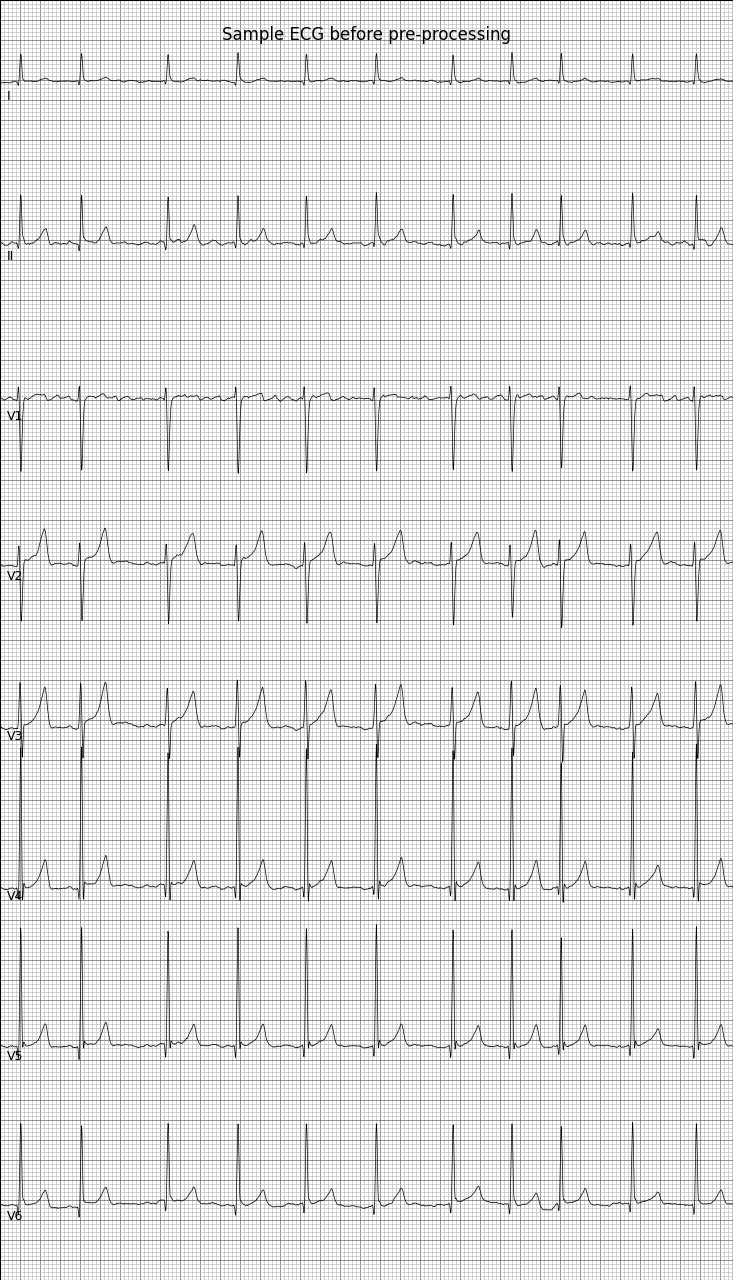

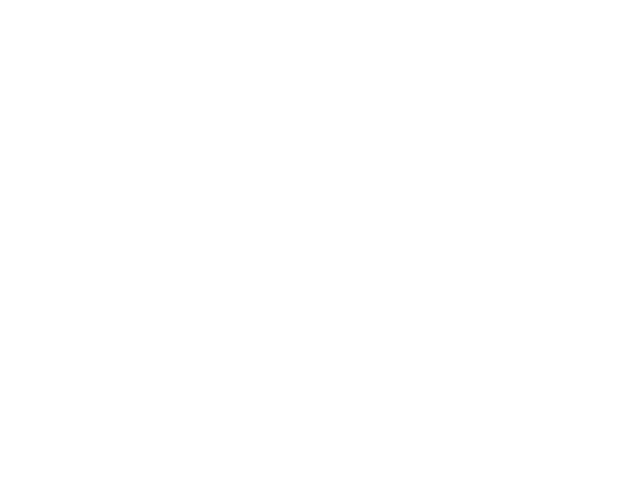

In [8]:
import ecg_plot
runfile("ecg-preprocessing/read_ecg.py")

PATH_TO_WFDB = 'codesubset/train/TNMG100046'
ecg_sample, sample_rate, _ = read_ecg(PATH_TO_WFDB)

# ECG plot
plt.figure()
lead = ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
ecg_plot.plot(ecg_sample, sample_rate=sample_rate, style='bw', row_height=8, lead_index=lead, columns=1, title='Sample ECG before pre-processing')
plt.show()


The preprocessing consist of:
- resampling all ECG traces to the sample sampling period (400 Hz). Option: ``--new_freq 400``
- zero padding if necessary such that all ECG have the same number of samples (4096). Option: ``--new_len 4096``.
- removing trends in the ECG signal. Option: ``--remove_baseline``
- remove possible power line noise. Option: ``--powerline 60``

You can run the script bellow to plot the same ECG after the preprocessing.  The script also use the  `ecg_plot` library (as you did above).  You can try also with different command line options to see how the preprocessing affects the signal that will be used by the model.

Namespace(path='codesubset/train/TNMG100046', save='', remove_baseline=True, new_len=4096, new_freq=400.0, scale=1, use_all_leads=False, powerline=60.0, fmt='wfdb')


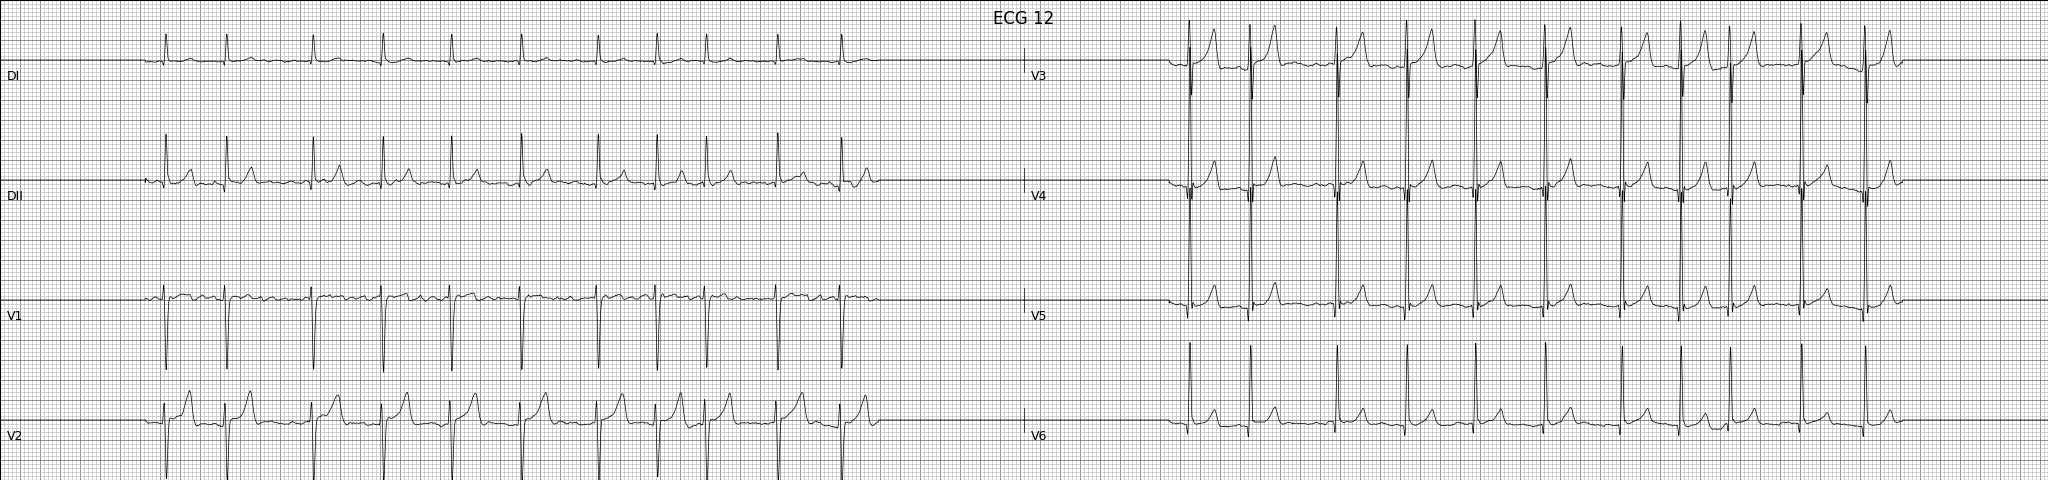

In [9]:
%run ecg-preprocessing/plot_from_ecg.py codesubset/train/TNMG100046 --new_freq 400 --new_len 4096 --remove_baseline --powerline 60


Next we perform the preprocessing in all exams and convert them into one single h5 file (see [here](https://www.h5py.org/#:~:text=The%20h5py%20package%20is%20a,they%20were%20real%20NumPy%20arrays.) for details about the format). The resulting h5 files contains the traces as arrays with the shape `(number of traces * sequence length * number of leads)` where sequence length is 4096 and number of leads is 8. 
The files `train.h5` and `test.h5` will be saved inside the folder `codesubset/`.

In [10]:
# 3. Generate train
if not exists('codesubset/train.h5'):
    !python ecg-preprocessing/generate_h5.py --new_freq 400 --new_len 4096 --remove_baseline --powerline 60 codesubset/train/RECORDS.txt codesubset/train.h5
# 3. Generate test
if not exists('codesubset/test.h5'):
    !python ecg-preprocessing/generate_h5.py --new_freq 400 --new_len 4096 --remove_baseline --powerline 60 codesubset/test/RECORDS.txt codesubset/test.h5

codesubset/train.h5 already exits. Using cached. Delete it manually to recieve it again!
codesubset/test.h5 already exits. Using cached. Delete it manually to recieve it again!


### Coding Task 1: Data Analysis

Before starting to model you have to analyse the dataset. You can be creative in your way of *getting a feeling* for the data. What you have to do is:
- plot an ECG after proprocessing saved in the hdf5 file. For this use the `ecg_plot()` example above and see below for how to access the preprocessed data in h5 format.

Some further ideas to explore are:
- check the balance of the data set,
- evaluate the distribution of age and sex of the patients,
- think about the performance that a best naive classifier would achieve, e.g. by random guessing or always predicting one class.

<br />

**How to access the data?**

You can acces the data in the h5 file in the following way
```
import h5py

PATH_TO_H5_FILE = 'codesubset/train.h5'
f = h5py.File(PATH_TO_H5_FILE, 'r')
data = f['tracings']
```
Then, `data[i]` is an numpy array of the $i$th ECG exam (including all time points and leads).


In [11]:
import h5py

PATH_TO_H5_FILE = 'codesubset/train.h5'
f = h5py.File(PATH_TO_H5_FILE, 'r')
data = f['tracings']

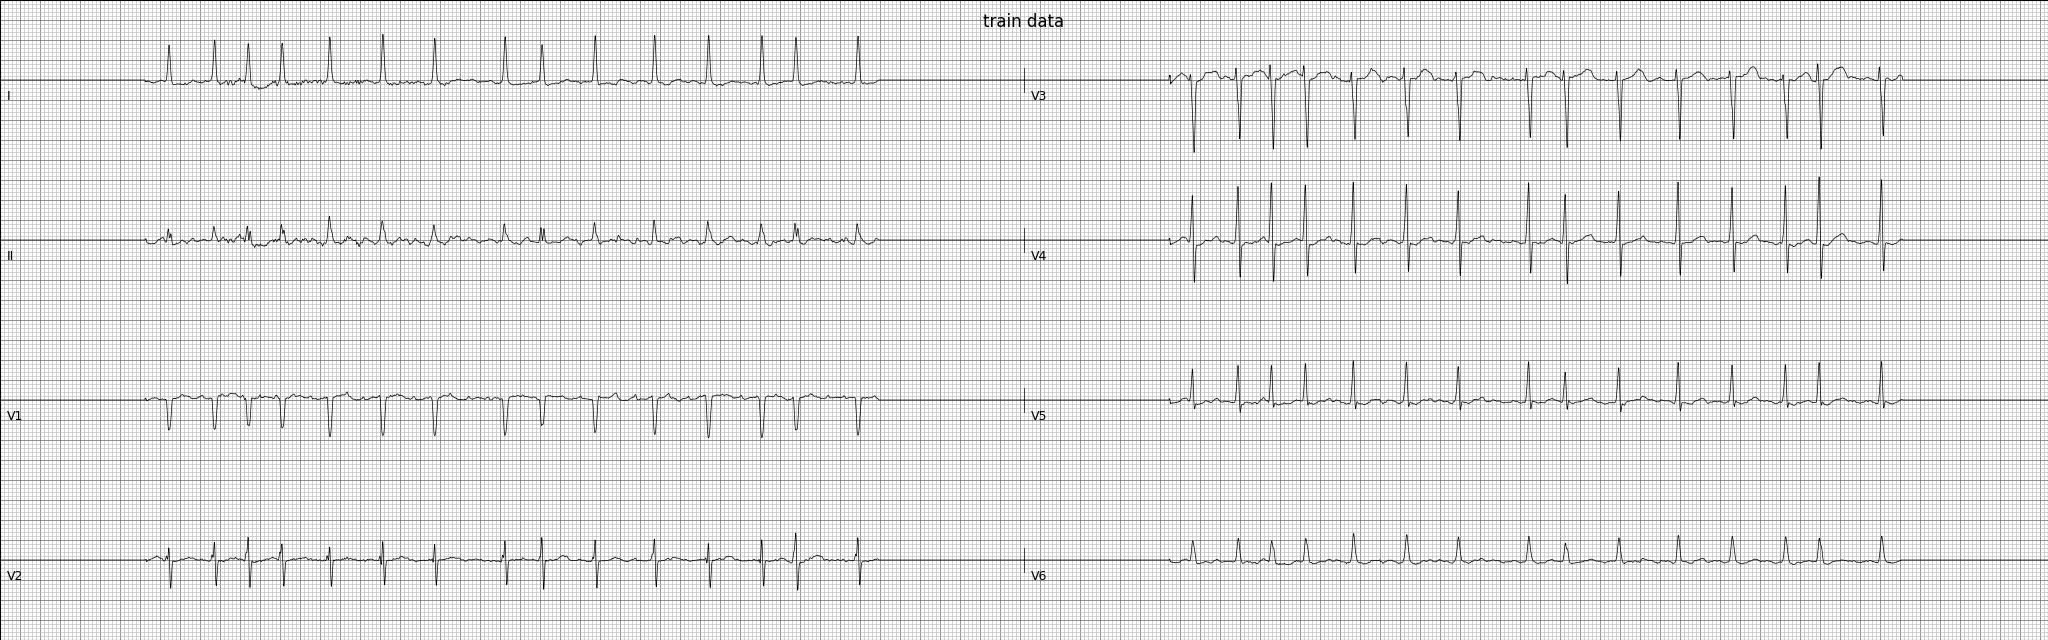

In [12]:
ecg_plot.plot(data[-1, :, :].transpose(1, 0), sample_rate=sample_rate, style='bw', lead_index=lead, row_height=8, title='train data')
plt.show()

In [13]:
meta_data = pd.read_csv('codesubset/train.csv')
ids_traces = [int(x.split('TNMG')[1]) for x in list(pd.read_csv('codesubset/train/RECORDS.txt', header=None)[0])] # Get order of ids in traces
INDEX_TO_ID = meta_data["id_exam"]
ID_TO_INDEX = {id: i for i, id in enumerate(INDEX_TO_ID)}   # map id to index
meta_data.set_index('id_exam', inplace=True)
meta_data = meta_data.reindex(ids_traces) # make sure the order is the same
meta_data["date_exam"] = meta_data["date_exam"].astype("datetime64[ms]")

def split_data_by_age_sex_af(data, age_range=5, min_age=10,  max_age=105):
    # Calculate the lower and upper age bounds for each age range
    age_ranges = np.arange(min_age, max_age, age_range)

    # Create an additional 'age_range' column based on the age bounds
    data['age_range'] = pd.cut(data['age'], bins=list(age_ranges) + [max_age])
    male_sick = data[(data['sex'] == 'M') & (data["AF"] == 1)].groupby(['age_range']).size().reset_index()[0]
    male_clear = data[(data['sex'] == 'M') & (data["AF"] == 0)].groupby(['age_range']).size().reset_index()[0]

    female_sick = data[(data['sex'] == 'F') & (data["AF"] == 1)].groupby(['age_range']).size().reset_index()[0]
    female_clear = data[(data['sex'] == 'F') & (data["AF"] == 0)].groupby(['age_range']).size().reset_index()
    age_labels = female_clear["age_range"]
    female_clear = female_clear[0]
    return data, age_ranges, age_labels, female_clear, male_clear, female_sick, male_sick
meta_data, age_ranges, age_labels, fc, mc, fs, ms = split_data_by_age_sex_af(meta_data)
meta_data

,id_patient,age,sex,AF,date_exam,age_range
id_exam,,,,,,
100046,178843,72,F,1,2013-04-02,"(70, 75]"
100067,38210,55,M,1,2013-04-02,"(50, 55]"
1001109,5408,49,F,0,2015-04-07,"(45, 50]"
1001493,19038,70,F,1,2015-04-07,"(65, 70]"
1001653,24719,55,M,1,2015-04-07,"(50, 55]"
...,...,...,...,...,...,...
9963,6186,56,F,0,2012-12-13,"(55, 60]"
997756,6576,61,F,0,2015-04-01,"(60, 65]"
998336,1225,27,F,0,2015-04-04,"(25, 30]"


In [14]:
# check the number of unique patients in the dataset
len(meta_data['id_patient']), len(meta_data['id_patient'].unique())

(10000, 10000)

<Axes: xlabel='date_exam'>

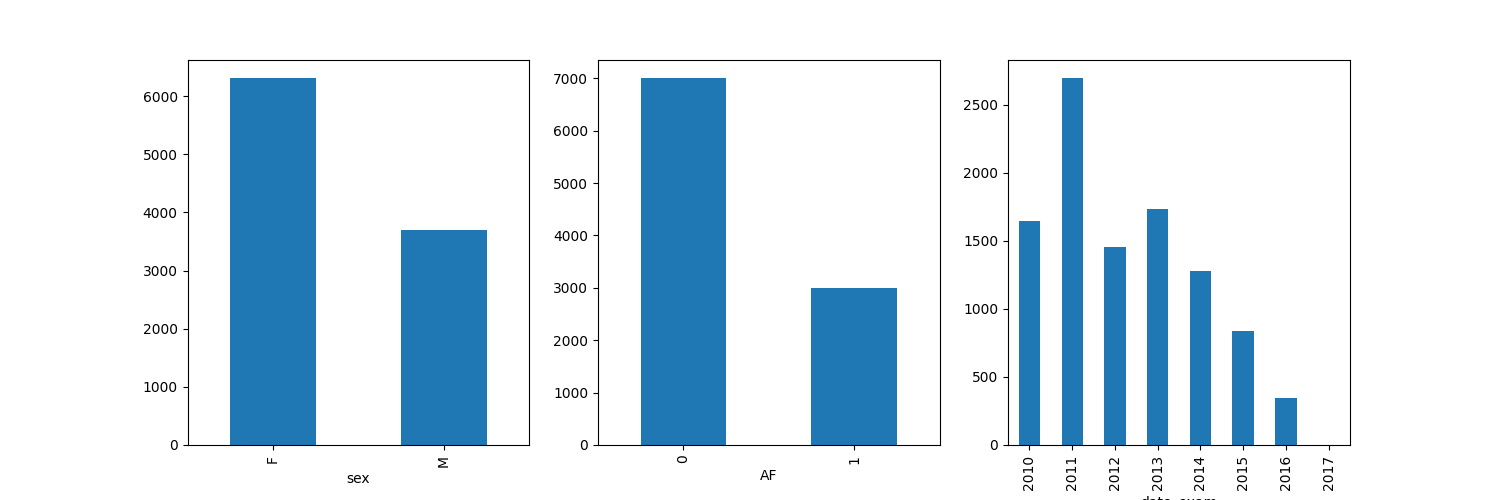

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
meta_data["sex"].groupby(meta_data["sex"]).count().plot(kind="bar", ax=ax[0])
meta_data["AF"].groupby(meta_data["AF"]).count().plot(kind="bar", ax=ax[1])
meta_data["date_exam"].groupby(meta_data["date_exam"].dt.year).count().plot(kind="bar", ax=ax[2])

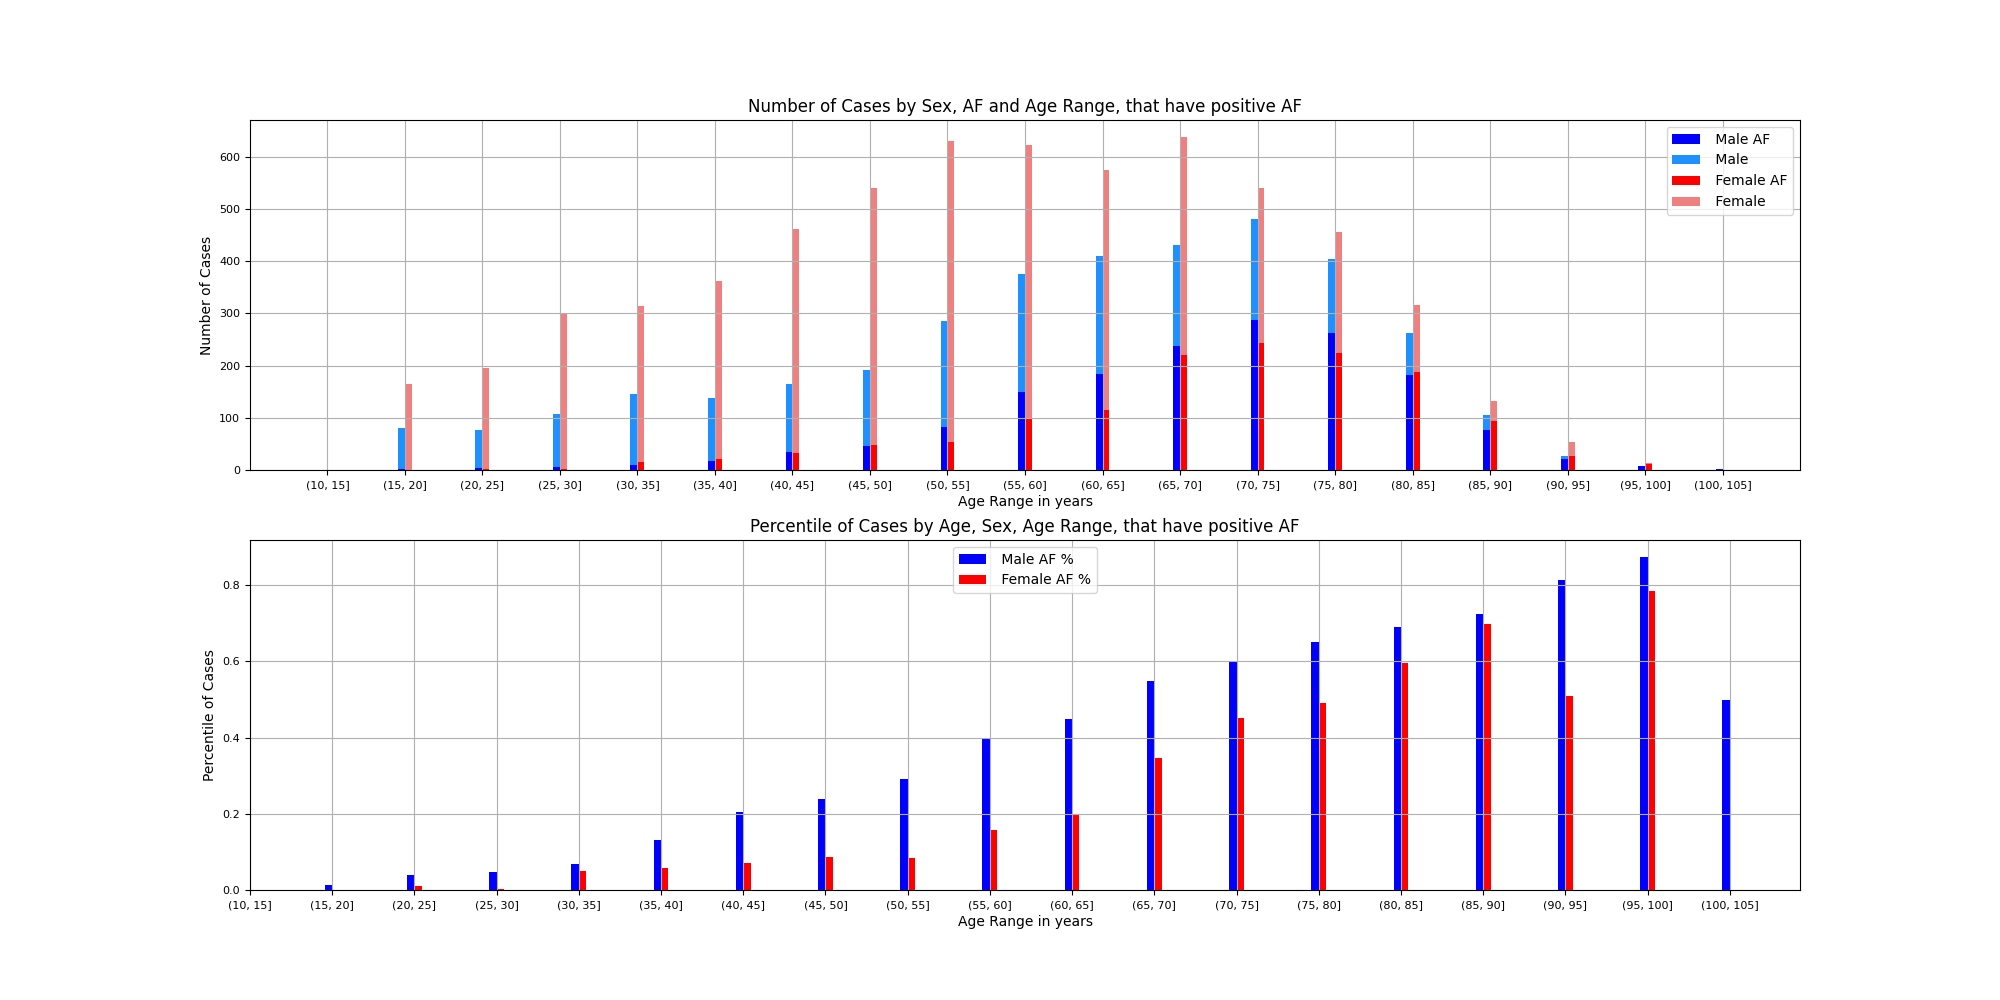

In [16]:

# Plotting the grouped bar plot
def plot_age_range_sex_af(ax, age_ranges, age_labels, fc, mc, fs, ms, bar_width=0.45, labelsize=8, prefix=""):
    ax.bar(age_ranges , ms, width=bar_width, label=f'{prefix} Male AF', color='blue')
    ax.bar(age_ranges , mc, width=bar_width, label=f'{prefix} Male', color='dodgerblue',  bottom=ms)
    ax.bar(age_ranges + bar_width, fs, width=bar_width, label=f'{prefix} Female AF', color='red')
    ax.bar(age_ranges + bar_width, fc, width=bar_width, label=f'{prefix} Female', color='lightcoral', bottom=fs)


    ax.set_xlabel(f'Age Range in years')
    ax.set_ylabel('Number of Cases')
    ax.set_title(f'Number of Cases by Sex, AF and Age Range, that have positive AF')
    ax.set_xticks(age_ranges + bar_width / 2)
    ax.set_xticklabels(age_labels)
    ax.tick_params(labelsize=labelsize)
    ax.legend()
    ax.grid(True)

def plot_age_sex_af_ratio(ax, age_ranges, age_labels, fc, mc, fs, ms, bar_width=0.45, labelsize=8, prefix=""):
    # compute the precental of male and female with HA
    ax.bar(age_ranges,  ms / (ms + mc), width=bar_width, label=f'{prefix} Male AF %', color='blue')
    ax.bar(age_ranges + bar_width, fs / (fs + fc), width=bar_width, label=f'{prefix} Female AF %', color='red')

    ax.set_xlabel(f'Age Range in years')
    ax.set_ylabel('Percentile of Cases')
    ax.set_title(f'Percentile of Cases by Age, Sex, Age Range, that have positive AF')
    ax.set_xticks(age_ranges  + bar_width / 2)
    ax.set_xticklabels(age_labels)
    ax.tick_params(labelsize=8)
    ax.legend()
    ax.grid(True)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))

plot_age_range_sex_af(ax1, age_ranges, age_labels, fc, mc, fs, ms)
plot_age_sex_af_ratio(ax2, age_ranges, age_labels, fc, mc, fs, ms)

plt.show()

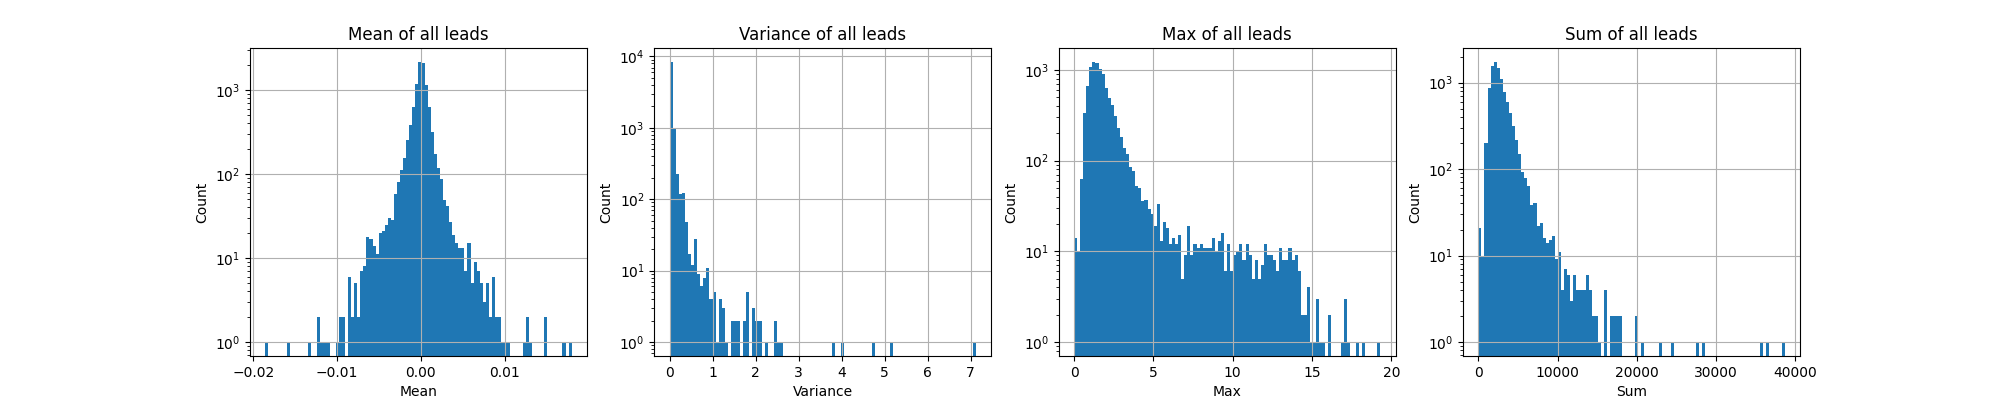

In [17]:
means = np.mean(data, axis=(1, 2))
variances = np.var(data, axis=(1, 2))
maxs = np.max(data, axis=(1, 2))
sums = np.sum(np.abs(data), axis=(1, 2))

fig, ax = plt.subplots(1, 4, figsize=(20, 4))
ax[0].hist(means, bins=100, log=True)
ax[0].set_title('Mean of all leads')
ax[0].set_xlabel('Mean')    
ax[0].set_ylabel('Count')
ax[0].grid(True)

ax[1].hist(variances, bins=100, log=True)
ax[1].set_title('Variance of all leads')
ax[1].set_xlabel('Variance')
ax[1].set_ylabel('Count')
ax[1].grid(True)

ax[2].hist(maxs, bins=100, log=True)
ax[2].set_title('Max of all leads')
ax[2].set_xlabel('Max')
ax[2].set_ylabel('Count')
ax[2].grid(True)

ax[3].hist(sums, bins=100, log=True)
ax[3].set_title('Sum of all leads')
ax[3].set_xlabel('Sum')
ax[3].set_ylabel('Count')
ax[3].grid(True)


In [18]:
sort_by={
    'variance': np.argsort(variances)[::-1],
    'mean': np.argsort(means)[::-1],
    'max': np.argsort(maxs)[::-1],
    'sum': np.argsort(sums)[::-1],
}

disp_func_dict = {
    "AF": lambda sort_stat: meta_data["AF"][INDEX_TO_ID[sort_by[sort_stat]]], 
    "sex": lambda sort_stat:  meta_data["sex"][INDEX_TO_ID[sort_by[sort_stat]]]=='F', 
}
sort_strat_drop=widgets.Dropdown(options=sort_by.keys(), value='variance', description='Sort By:')
disp_func_drop=widgets.Dropdown(options=disp_func_dict.keys(), value='AF', description='Disp Func:')
case_slide=widgets.IntSlider(min=0, max=len(meta_data)-1, step=1, value=0, disabled=False, continuous_update=False, )

In [19]:
@widgets.interact(
                sort_stat=sort_strat_drop,
                disp_func=disp_func_drop,
                )
def plot_freq(sort_stat, disp_func):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(np.arange(len(meta_data)), disp_func_dict[disp_func](sort_stat), label=sort_stat)
    plt.show()

interactive(children=(Dropdown(description='Sort By:', options=('variance', 'mean', 'max', 'sum'), value='vari…

In [20]:


@widgets.interact(
                sort_stat=sort_strat_drop,
                case=case_slide,
                )
def ecg_data_plot(sort_stat, case):
    current_case = sort_by[sort_stat][case]
    print(f"Case ID {INDEX_TO_ID[current_case]}, {current_case}")
    print(meta_data.iloc[current_case])
    ecg_plot.plot(data[current_case].transpose(1, 0), sample_rate=sample_rate, style='bw', lead_index=lead, row_height=8, title=sort_stat)
    plt.show()


interactive(children=(Dropdown(description='Sort By:', options=('variance', 'mean', 'max', 'sum'), value='vari…

### Explanation task 1: Data Analysis

Please explain your main findings of the data analysis task in a few bullet points. Explain also what the preprocessing does and why it is necessary.

<br />

**<font color='red'>Vilhelm can you add some things about preprocessing :</font>**

Data Analysis Findings:

* Class Imbalance: The initial data analysis reveals a noticeable class imbalance within the dataset. Specifically, the number of samples for each class is disparate, potentially introducing bias in subsequent classification tasks. The training set contains around 3,000 cases of atrial fibrillation (AF) and roughly 7,000 cases of non-AF. This imbalance raises concerns regarding model performance and generalizability.

* Balancing Strategy: Given the imbalanced nature of the data, it becomes crucial to address this issue to avoid favoring the majority class during classification. To mitigate this, a method to balance the classes is proposed. This involves oversampling the minority class by augmenting it with additional instances until an equal representation of samples for each class is achieved. This approach aims to rectify the bias in favor of the majority class and improve overall classification accuracy.

* Sex Distribution: Similarly, the analysis identifies an uneven distribution across sexes within the dataset. This disparity could influence the model's performance, leading to a potential gender bias in predictions. Addressing this disparity, alongside class imbalance, is pivotal to ensure unbiased and fair classification outcomes.

* Age Distribution: The age distribution of participants seems to lean towards older age groups. This skew might inadvertently introduce a bias towards older individuals in AF cases, potentially overlooking occurrences of AF among younger participants. Addressing this bias becomes challenging, as the dataset is limited to the available data. However, it is crucial to be aware of this bias and its potential impact on model performance.

* Data Representation: Analyzing the variance of the ECG data exposes certain anomalies. There are instances with erratic oscillations that might appear nonsensical to human interpretation. Conversely, some cases exhibit zeroed-out values. These anomalies could hinder model learning or introduce noise. Deciding whether to eliminate such cases or retain them while implementing regularization techniques requires careful consideration since the test set seems to contain similar instances.

* Fairness: It's challenging to conduct a thorough analysis to ensure a fair representation of the data. This difficulty arises from the need to capture the data distribution accurately without inadvertently biasing against outliers in the process.

---
## Model

The model class consists of two methods: 
- `__init__(self, args)`: This methods initializes the class, e.g. by using `mymodel=ModelBaseline(args)`.
- `forward(self,input_data)`: This method is called when we run `model_output=mymodel(input_data)`.

The dimension of the input data is  `(batch size * sequence length * number of leads)`. Where **batch size** is a hyperparameter, **sequence length** is the number of ECG time samples (=4096) and **number of leads** (=8).

The `ModelBaseline` (provided below) is a 2 layer model with one convolutional layers and one linear layer. Some explanations: 
- The conv layer downsamples the input traces from 4096 samples to 128 samples and increases the number of channels from 8 (=number of leads) to 32. Here we use a kernel size of 3.
- The linear layer uses the flattened output from the conv and outputs one prediction. Since we have a binary problem, a single prediction is sufficient.


In [21]:
class Baseline(nn.Module):
    def __init__(self, out_features=1, name="placeholder",  training_args={}):
        super(Baseline, self).__init__()
        self.kernel_size = 3
        self.name = f'Baseline_F{out_features}'
        self.kvargs = {
            'name': self.name,
            'training_args': training_args,
            'out_features': out_features
        }
        self.out_features = out_features

        # conv layer
        downsample = self._downsample(4096, 128)
        self.conv1 = nn.Conv1d(in_channels=8, 
                               out_channels=32, 
                               kernel_size=self.kernel_size, 
                               stride=downsample,
                               padding=self._padding(downsample),
                               bias=False)
        
        # linear layer
        self.lin = nn.Linear(in_features=32*128,
                             out_features=out_features)
        
        # ReLU
        self.relu = nn.ReLU()

    def _padding(self, downsample):
        return max(0, int(np.floor((self.kernel_size - downsample + 1) / 2)))

    def _downsample(self, seq_len_in, seq_len_out):
        return int(seq_len_in // seq_len_out)


    def forward(self, x):
        x= x.transpose(2,1)

        x = self.relu(self.conv1(x))
        x_flat= x.view(x.size(0), -1)
        x = self.lin(x_flat)

        return x
    

### Coding Task 2: Define your model

In the cell below you have to define your model. You can be inspired by the baseline model above but you can also define any other kind of neural network architecture.

In [22]:
class Conv1Block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, steps=2, stride=1):
        super().__init__()
        self.steps = steps
        self.layers = nn.Sequential(
            nn.Conv1d(in_channels=in_channels,
                        out_channels=out_channels,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=kernel_size//2,
                        bias=False),
            nn.ReLU())
        self.skip_layers = nn.Sequential(
            *[ 
                nn.Sequential(
                nn.BatchNorm1d(out_channels), 
                nn.Conv1d(in_channels=out_channels,
                            out_channels=out_channels,
                            kernel_size=kernel_size,
                            stride=1,
                            padding=kernel_size//2,
                            bias=False),
                nn.ReLU()
            )for _ in range(steps)]
        )
    
    def forward(self, x):
        x = self.layers(x)
        if self.steps > 0:
            x = x + self.skip_layers(x)
        return x
    
class Model(nn.Module):
    def __init__(self, 
                 kernel_size=43, 
                 num_layers=7, 
                 steps=2, 
                 dropout=0.13, 
                 lin_steps=1, 
                 in_channels=8, 
                 out_features=1, 
                 data_width=4096, 
                 name="placeholder", 
                 postfix="",
                 training_args={},
                 ):
        super().__init__()
        self.name = f"Model_F{out_features}{postfix}"
        self.kvargs = {
            "name": self.name,
            "kernel_size": kernel_size,
            "num_layers": num_layers,
            "steps": steps,
            "dropout": dropout,
            "lin_steps": lin_steps,
            "in_channels": in_channels,
            "out_features": out_features,
            "data_width": data_width,
            "training_args": training_args,
        }
        self.out_features = out_features

        self.encoder = nn.Sequential(
            *[ Conv1Block(in_channels*(2**i), in_channels*(2**(i+1)), kernel_size, steps, stride=2) for i in range(num_layers)])
        self.reducer = nn.Sequential(
            *[ Conv1Block(in_channels*(2**i), in_channels*(2**(i-1)), kernel_size, steps, stride=1) for i in range(num_layers, 0, -1)], 
            Conv1Block(8, 1, kernel_size, steps, stride=1)
            )
        # linear layer
        out_channels = data_width//(2**(num_layers))
        self.lin = nn.Sequential(
            *[nn.Sequential(
                nn.Linear(in_features=out_channels,
                                out_features=out_channels), 
                nn.Dropout(dropout), 
                nn.ReLU()
            ) for _ in range(lin_steps)],
            nn.Linear(in_features=out_channels,
                                out_features=out_features),
        )
        

    def forward(self, x):
        x= x.transpose(2,1)
        x = self.encoder(x)
        x = self.reducer(x)
        x_flat= x.view(x.size(0), -1)
        x = self.lin(x_flat)
        return x

class Model_V2(nn.Module):
    def __init__(self, 
                 kernel_size=21, 
                 encode_layers=8,
                 encoder_out_channels=32,
                 reduce_layers=4,
                 reduce_out_channels=11,
                 steps=2, 
                 dropout=0.05, 
                 lin_steps=3, 
                 lin_dims=352, 
                 in_channels=8,
                 out_features=1, 
                 data_width=4096, 
                 name="placeholder", 
                 postfix="",
                 training_args={}
                 ):
        super().__init__()
        self.name = f"Model_V2_F{out_features}{postfix}"
        self.kvargs = {
            "name": self.name,
            "kernel_size": kernel_size,
            "encode_layers": encode_layers,
            "encoder_out_channels": encoder_out_channels,
            "reduce_layers": reduce_layers,
            "reduce_out_channels": reduce_out_channels,
            "steps": steps,
            "dropout": dropout,
            "lin_steps": lin_steps,
            "lin_dims": lin_dims,
            "in_channels": in_channels,
            "out_features": out_features,
            "training_args": training_args,
        }
        self.out_features = out_features
        encoder_channels = np.linspace(in_channels, encoder_out_channels, encode_layers+1, dtype=int)
        self.encoder = nn.Sequential(
            *[ Conv1Block(in_c, out_c, kernel_size, steps, stride=2) for in_c, out_c in zip(encoder_channels[:-1], encoder_channels[1:])])
        
        reducer_channels = np.linspace(encoder_out_channels, reduce_out_channels, reduce_layers+1, dtype=int)
        self.reducer = nn.Sequential(
            *[ Conv1Block(in_c, out_c, kernel_size, steps,  stride=1) for in_c, out_c in zip(reducer_channels[:-1], reducer_channels[1:])]
            )
        # linear layer
        out_channels = reduce_out_channels*data_width//(2**(encode_layers))
        self.lin = nn.Sequential(
            nn.Linear(in_features=out_channels,
                                out_features=lin_dims),
            nn.ReLU(),
            *[nn.Sequential(
                nn.Linear(in_features=lin_dims,
                                out_features=lin_dims), 
                nn.Dropout(dropout), 
                nn.ReLU()
            ) for _ in range(lin_steps)],
            nn.Linear(in_features=lin_dims,
                                out_features=out_features),
        )
        

    def forward(self, x):
        x= x.transpose(2,1)
        x = self.encoder(x)
        x = self.reducer(x)
        x_flat= x.view(x.size(0), -1)
        x = self.lin(x_flat)
        return x
    
    

In [23]:
from torchsummary import summary

base_model = Baseline()

summary(base_model, (4096, 8));

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv1d: 1-1                            [-1, 32, 128]             768
├─ReLU: 1-2                              [-1, 32, 128]             --
├─Linear: 1-3                            [-1, 1]                   4,097
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
Total mult-adds (M): 0.10
Input size (MB): 0.12
Forward/backward pass size (MB): 0.03
Params size (MB): 0.02
Estimated Total Size (MB): 0.17


In [24]:
deep_model = Model()

print(deep_model(torch.randn(1, 4096, 8)).shape)

summary(deep_model, (4096, 8), depth=2);

torch.Size([1, 1])
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1024, 32]            --
|    └─Conv1Block: 2-1                   [-1, 16, 2048]            27,584
|    └─Conv1Block: 2-2                   [-1, 32, 1024]            110,208
|    └─Conv1Block: 2-3                   [-1, 64, 512]             440,576
|    └─Conv1Block: 2-4                   [-1, 128, 256]            1,761,792
|    └─Conv1Block: 2-5                   [-1, 256, 128]            7,046,144
|    └─Conv1Block: 2-6                   [-1, 512, 64]             28,182,528
|    └─Conv1Block: 2-7                   [-1, 1024, 32]            112,726,016
├─Sequential: 1-2                        [-1, 1, 32]               --
|    └─Conv1Block: 2-8                   [-1, 512, 32]             45,090,816
|    └─Conv1Block: 2-9                   [-1, 256, 32]             11,273,216
|    └─Conv1Block: 2-10                  [-1, 128, 32]             2,818,56

In [25]:
deep_model_v2 = Model_V2()

print(deep_model_v2(torch.randn(1, 4096, 8)).shape)

summary(deep_model_v2, (4096, 8), depth=2);

torch.Size([1, 1])
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32, 16]              --
|    └─Conv1Block: 2-1                   [-1, 11, 2048]            6,974
|    └─Conv1Block: 2-2                   [-1, 14, 1024]            11,522
|    └─Conv1Block: 2-3                   [-1, 17, 512]             17,204
|    └─Conv1Block: 2-4                   [-1, 20, 256]             24,020
|    └─Conv1Block: 2-5                   [-1, 23, 128]             31,970
|    └─Conv1Block: 2-6                   [-1, 26, 64]              41,054
|    └─Conv1Block: 2-7                   [-1, 29, 32]              51,272
|    └─Conv1Block: 2-8                   [-1, 32, 16]              62,624
├─Sequential: 1-2                        [-1, 11, 16]              --
|    └─Conv1Block: 2-9                   [-1, 26, 16]              45,968
|    └─Conv1Block: 2-10                  [-1, 21, 16]              30,072
|    └─Conv1Block: 2-11    

### Explanation Task 2: Final Model
Please explain and motivate in short sentences or bullet points the choice of your final model.

<br />


**<font color='red'>Your explanation here:</font>**

The final model is Model with a F1  score of 0.965 on the validation set. The chosen hyperparameters are as follows:

* kernel_size=43:
The kernel size determines the amount of input data the filter will consider at once. Since the kernel size is so large, it indicates that the receptive field is crucial, thus allowing the model to capture comprehensive ECG patterns.

* num_layers=7:
This pertains to the number of convolution layers the model contains. Since the model is so deep, it suggests there are some non-linearities in the data that the model is trying to capture.

* steps=2:
Steps refer to skip connection steps that allow information to bypass certain layers. The skip connections increase the overall depth of the model and seem to improve performance.

* lin_steps=1:
This refers to the number of linear layers in the model. The model did not benefit from more than one linear layer, probably due to the risk of overfitting.

* dropout=0.13:
Dropout is a regularization technique that randomly turns off a fraction of neurons during training. A 0.13 dropout rate was effective in preventing overfitting.

* learning_rate=1e-4:
The learning rate dictates how much the model adjusts in response to the error it perceives at each training step. A learning rate of 5e-4 is neither too high (which could overshoot optimal values) nor too low (which could make training too slow). Given the data constraints, this rate aims to achieve good performance without overfitting.

* weight_decay=1e-04:
Weight decay is a regularization method that had a positive impact.



---
## Train function

The function `train(...)` is called to in every epoch to train the model. The function loads the training data, makes predictions, compares predictions with true labels in the loss function and adapting the model parameters using stochastic gradient descent.

In the code cell below there is the basic structure to load data from the data loader and to log your loss. The arguments of the function are explained by the use in the `main(...)` function below.

If you are unfamiliar with PyTorch training loops, then this official [tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) might help (especially section "4. Train your Network").

### Coding Task 3: Fill training loop

Fill the code cell below such that the model is training when `train(...)` is called.

In [26]:
def train_loop(dataloader, model, optimizer, lr_scheduler, loss_function, device):
    # model to training mode (important to correctly handle dropout or batchnorm layers)
    model.train()
    # allocation
    total_loss = 0  # accumulated loss
    n_entries = 0   # accumulated number of data points
    # training loop
    for it, (traces, diagnoses) in enumerate(dataloader):
        # data to device (CPU or GPU if available)
        traces, diagnoses = traces.to(device), diagnoses.to(device)

        optimizer.zero_grad()  # set gradients to zero
        output = model(traces) # forward pass
        loss = loss_function(output, diagnoses) # compute loss
        loss.backward() # compute gradients
        optimizer.step() # update parameters

                # Update learning rate with lr-scheduler
        if lr_scheduler:
            lr_scheduler.step()

        # Update accumulated values
        total_loss += loss.detach().cpu().numpy()
        n_entries += len(traces)


    return total_loss / n_entries

---
## Eval function

The `eval(...)` function is similar to the `train(...)` function but is used to evaluate the model on validation data without adapting the model parameters. You can prohibit computing gradients by using a `with torch.no_grad():` statement.

Currenlty only the loss is logged here. Additionally you have to collect all your predictions and the true values in order to compute more metrics such as AUROC.

### Coding Task 4: Fill evaluation loop
Fill the code cell below such we obtain model predictions to evaluate the validation loss and collect the predictoin in order to compute other validation metrics in the `main(...)` function.

In [27]:
def eval_loop(dataloader, model, loss_function, device):
    # model to evaluation mode (important to correctly handle dropout or batchnorm layers)
    model.eval()
    # allocation
    total_loss = 0  # accumulated loss
    n_entries = 0   # accumulated number of data points
    valid_pred, valid_true = [], []
    # evaluation loop
    for it, (traces_cpu, diagnoses_cpu) in enumerate(dataloader):
        # data to device (CPU or GPU if available)
        traces, diagnoses = traces_cpu.to(device), diagnoses_cpu.to(device)

        with torch.no_grad(): # no gradients needed
            output = model(traces) # forward pass

        if model.out_features > 1:
            pred = torch.sigmoid(output[:,0]).unsqueeze(1)
            diagnoses_cpu = diagnoses_cpu[:,0].unsqueeze(1)
        else:
            pred = torch.sigmoid(output)

        valid_pred.append(pred.cpu().numpy())
        valid_true.append(diagnoses_cpu.numpy())
        loss = loss_function(output, diagnoses) # compute loss
        
        # Update accumulated values
        total_loss += loss.detach().cpu().numpy()
        n_entries += len(traces)

    return total_loss / n_entries, np.vstack(valid_pred), np.vstack(valid_true)

---
## Run Training

In the code cell below there are some initial (non-optimal!) training hyperparameters. Further, we combine everything from above into training code. That means that we build the dataloaders, define the model/loss/optimizer and then train/validate the model over multiple epochs. Here, we save the model with the lowest validation loss as the best model.

### Coding Task 5: Combine everything to train/validate the model

The following tasks are necessary in the code below
- split the data into training and validation data
- define the loss function
- decide and implement validation metric(s) to evaluate and compare the model on

Optional task:
- include learning rate scheduler
- take specific care about possible data inbalance

### Coding Task 6: Run your model and adapt hyperparameters

After you combined everything in task 5, now you run the code to evaluate the model. Based on the resulting validation metrics you tune
- the training hyperparameters
- the model architecture
- the model hyperparameters.

### Explanation Task 3: Hyperparameter
Please explain and motivate in short sentences or bullet points the final choice of hyperparamer and how you developed them.

<br />


**<font color='red'>Your explanation here:</font>**

In our design, we are presented with a set of hyperparameters that are amenable to tuning. Each hyperparameter comes with a predefined range of values, selected to be explored systematically. We have established these ranges based on careful consideration, and we elucidate the rationale behind each hyperparameter below. To efficiently explore these hyperparameters, we employ Bayesian optimization, facilitated by the Optuna framework. This approach allows us to intelligently navigate the hyperparameter search space, enhancing the effectiveness of our design process.


#### For training:
- Learning Rate: We have opted to investigate the learning rate within a range spanning from 1e-8 to 1e-2. This choice is rooted in the fact that our available data is constrained. Our goal is to identify the highest learning rate that facilitates convergence without triggering overfitting on the limited dataset. To systematically explore this range, we have selected a logarithmic scale. This scale allows us to effectively navigate the learning rate spectrum, capturing both the finer and broader nuances of its impact on model performance.
- Weight Decay: We have chosen to examine the impact of weight decay over a range spanning from 1e-8 to 1e-2. Weight decay serves as a regularization method that discourages excessive weights within the model. Given our limited understanding of its effects in our context, this choice is somewhat arbitrary. Nevertheless, by systematically exploring this range, we aim to uncover potential insights into how weight decay influences our model's behavior and performance.
- Batch Size: Since batch size and the learning has some correlation we have chosen to fix the batch size to 32 and only tune the learning rate.
- Number of Epochs: Initially, we have opted to set the number of epochs to 10 to facilitate faster training. However, as our approach evolves and incorporates data augmentation, along with a more refined model selection process, we have made the deliberate choice to extend the number of epochs to 100. This adjustment allows our model to thoroughly learn from the augmented data and capitalize on the refined model choices.
 
#### For the model:
- Kernel Size: The kernel size, along with the model's depth, fundamentally determines the model's receptive field. We have chosen to systematically explore the kernel size across a range from 3 to 65. This selection is underpinned by the goal of ensuring the model's receptive field is capable of adequately encompasses the entire heart's sinus rhythm, encompassing the distinct P, Q, R, S, and T waves. By allowing the model to capture these comprehensive ECG patterns, both across different leads and deeper within the model's layers, we enable the identification of intricate cardiac rhythm nuances. This rationale is rooted in human ECG interpretation practices.

- Number of Convolution Layers: We have undertaken an investigation into the number of convolution layers, ranging from 1 to 7. This selection is influenced by the limitation of the computation time and GPU memory, prompting us to discern the optimal number of convolution layers that lead to convergence without inducing overfitting within the limitations of the data. Employing a linear scale for exploration, we intend to systematically traverse the convolution layer possibilities, thereby capturing a comprehensive view of their influence on model performance. This approach enables us to discern patterns and nuances across different layer counts, enhancing our understanding of their effects on model behavior.

- Skip Connections Steps: We have chosen to investigate the impact of skip connections steps within a range spanning from 1 to 5. This choice is rooted in the fact that skip connections facilitate the flow of information across different layers, thereby enhancing the model's ability to learn from the data. By systematically exploring this range, we aim to uncover how skip connections influence our model's behavior and performance.

- Dropout: We have chosen to investigate the impact of dropout within a range spanning from 0 to 0.5. This choice is rooted in the fact that dropout serves as a regularization method that prevents overfitting.

- Out Features: In our investigation, we considered the potential utility of predicting not only atrial fibrillation (AF) but also the variables of sex and age. This approach aimed to experiment with multi-task learning, introducing a broader context to our model's predictions. The underlying idea is that accurate predictions of a patient's age and sex could enhance the model's ability to correctly predict AF, providing additional confidence to the operator using the system. However, due to the absence of this supplementary information in the test data, our exploration of this concept has been somewhat limited.

- Number of Linear Layers: Our inquiry delves into understanding the effect of the number of linear layers, ranging from 1 to 3. Given the parameter-intensive nature of linear layers, we have deliberately kept our range relatively small.

#### For the model v2:
- Kernel Size: Same as above

- Number of Encode layers: Same as in Number of Convolution Layers
- Number of Output Channels in Encoder: In contrast to doubling the number of channels in each layer, we have taken a linear approach to gradually increase the number of output channels. This choice provides greater flexibility in configuring the model architecture. The range for this exploration spans from 32 to 1024.
- Number of Reduction Layers: As we reduce image dimensions while increasing channel count in the encoder, it often results in a substantial number of parameters in subsequent linear layers. To address this, we employ reduction layers to diminish channel count but maintain image size. Our investigation into reduction layers spans a range from 1 to 7. 
- Number of Output Channels in Reduction Layers: The gradual reduction in channel count within the reduction layers is guided by the objective of reaching a specific value. Our exploration encompasses a range from 1 to 32 for this target value.

- number of skip connections steps: Same as above

- Dropout: Same as above

- number of linear layers: Same as above

- Number of Output Features in Linear Layers: In our pursuit of managing intermediate linear layer parameters, we've elected to constrain the number of output features. Our exploration encompasses values ranging from 32 to 512. This range choice is driven by the goal to strike a balance between model complexity and efficient information processing.


#### The final choice of hyperparameters:

For model F1 on the validation set of 0.965:
- kernel_size=43
- num_layers=7
- steps=2
- lin_steps=1
- dropout=0.13
- leraning_rate=1e-4
- weight_decay=1e-04

for model v2 F1 on the validation set of 0.964:
- kernel_size=21
- encode_layers=8
- encoder_out_channels=32
- reduce_layers=4
- reduce_out_channels=11
- steps=2
- dropout=0.05
- lin_steps=3
- lin_dims=352
- leraning_rate=5e-4
- weight_decay=1e-04



In [28]:
import random 


def set_seed(seed: int = 42) -> None:
    """Set the random seed for reproducibility"""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)



def split_id_exam(meta_data, test_split=0.3, min_samples=10, seed=42):
    set_seed(seed)
    # get all the sick males
    age_range_m_sick = meta_data[(meta_data['sex'] == 'M') & (meta_data["AF"] == 1)]
    # get all the heathy males
    age_range_m_clear = meta_data[(meta_data['sex'] == 'M') & (meta_data["AF"] == 0)]

    # get all the sick females
    age_range_f_sick = meta_data[(meta_data['sex'] == 'F') & (meta_data["AF"] == 1)]
    # get all the heathy females
    age_range_f_clear = meta_data[(meta_data['sex'] == 'F') & (meta_data["AF"] == 0)]

    # split data into train and test
    train = []
    test = []

    for age_range_data  in [age_range_m_sick, age_range_m_clear, age_range_f_sick, age_range_f_clear]:
        # groupe each group by age range 
        for age, indexes in age_range_data.groupby(['age_range']).indices.items():
            if len(indexes) == 0:
                continue
            # shuffle the indexes to make a random split
            random.shuffle(indexes)
            # prioritize to get age representation in the test set
            split_index = max(int(len(indexes) * test_split), min_samples)
            test.extend(age_range_data.iloc[indexes[:split_index]].index.values)

            # if there is enough data put the rest in the train set
            if len(indexes) > split_index:
                train.extend(age_range_data.iloc[indexes[split_index:]].index.values)

    print("train: ", len(train))
    print("test: ", len(test))
    assert len(train) + len(test) == len(meta_data)
    train = [ID_TO_INDEX[t] for t in train]
    test = [ID_TO_INDEX[t] for t in test]

    # validate that not train and test have the same id
    assert len(set(train).intersection(set(test))) == 0
    
    return sorted(train), sorted(test) 

def equal_split_id_exam(meta_data, test_split=0.3, min_samples=10, seed=42):
    set_seed(seed)
    # get all the sick males
    age_range_m_sick = meta_data[(meta_data['sex'] == 'M') & (meta_data["AF"] == 1)]
    # get all the heathy males
    age_range_m_clear = meta_data[(meta_data['sex'] == 'M') & (meta_data["AF"] == 0)]

    # get all the sick females
    age_range_f_sick = meta_data[(meta_data['sex'] == 'F') & (meta_data["AF"] == 1)]
    # get all the heathy females
    age_range_f_clear = meta_data[(meta_data['sex'] == 'F') & (meta_data["AF"] == 0)]

    # split data into train and test
    train = []
    test = []

    for age_range_data_sick,  age_range_data_clear in [(age_range_m_sick, age_range_m_clear), (age_range_f_sick, age_range_f_clear)]:
        # groupe each group by age range 
        for (age_sick, indexes_sick), (age_clear, indexes_clear) in zip(age_range_data_sick.groupby(['age_range']).indices.items(), age_range_data_clear.groupby(['age_range']).indices.items()):
            # if there is enough data put the rest in the train set
            if len(indexes_sick) == 0:
                train.extend(age_range_data_clear.iloc[indexes_clear].index.values)
                continue
            # shuffle the indexes to make a random split
            random.shuffle(indexes_sick), random.shuffle(indexes_clear)
            # prioritize to get age representation in the test set
            split_index = max(int(len(indexes_sick) * test_split), min_samples)
            test.extend(age_range_data_sick.iloc[indexes_sick[:split_index]].index.values)
            test.extend(age_range_data_clear.iloc[indexes_clear[:split_index]].index.values)
            train_sick, train_clear = [], []
            if len(indexes_sick) > split_index:
                train_sick = age_range_data_sick.iloc[indexes_sick[split_index:]].index.values
            if len(indexes_clear) > split_index:
                train_clear = age_range_data_clear.iloc[indexes_clear[split_index:]].index.values
                
            if len(train_sick) < len(train_clear) and len(train_sick) > 0:
                len_diff = int(0.5+len(train_clear)/len(train_sick))
                train_sick = np.repeat(train_sick, len_diff)
            elif len(train_sick) > len(train_clear) and len(train_clear) > 0:
                len_diff = int(0.5+len(train_sick)/len(train_clear))
                train_clear = np.repeat(train_clear, len_diff)
            train.extend(train_sick)
            train.extend(train_clear)

    print("train: ", len(train))
    print("test: ", len(test))

    train = [ID_TO_INDEX[t] for t in train]
    test = [ID_TO_INDEX[t] for t in test]

    # validate that not train and test have the same id
    assert len(set(train).intersection(set(test))) == 0, len(set(train).intersection(set(test)))
    
    return sorted(train), sorted(test) 
def validate_data(train_index, val_index, meta_data, dataset, result, func):
    count_lables = 0
    count_array = 0
    for index in train_index + val_index:
        array, label = dataset[index]
        label = int(label)
        if meta_data.iloc[index]['AF'] != label:
            count_lables += 1
            print("wrong lable", index, meta_data.iloc[index]['AF'], label)
        if abs(result[index] - func(array)) > 1e-6:
            count_array += 1
            print("wrong array", index, result[index] - func(array))
    print("wrong lable count: ", count_lables)
    print("wrong array count: ", count_array)

In [29]:
batch_size = 32

In [30]:
from torch.utils.data import TensorDataset, random_split, DataLoader, Dataset    

class AugmentIntensity:
    """Normalize the image in a sample.
    """
    def __init__(self, augment_intensity=(0.9, 1.1)):
        self.augment_intensity = augment_intensity

    def __call__(self, sample):
        min_intensity, max_intensity = self.augment_intensity
        tensor, label = sample
        # add random noise to the tensor with values between min_intensity and max_intensity
        tensor = tensor * (torch.rand(tensor.shape) * (max_intensity - min_intensity) + min_intensity)
        return tensor, label
    
class AugmentGaussianNoise:
    """Normalize the image in a sample.
    """
    def __init__(self, augment_noise=(0, 0.01)):
        self.augment_noise = augment_noise

    def __call__(self, sample):
        mean, std = self.augment_noise
        tensor, label = sample
        # add random noise to the tensor 
        tensor = tensor + torch.randn(tensor.shape) * std + mean
        return tensor, label
    
class AugmentShiftData:
    """Normalize the image in a sample.
    """
    def __init__(self, augment_shift=(-0.1, 0.1)):
        self.augment_shift = augment_shift

    def __call__(self, sample):
        min_shift, max_shift = self.augment_shift
        tensor, label = sample
        # shift all values in the tensor with values between min_shift and max_shift
        tensor = torch.roll(tensor, shifts=int(np.random.uniform(min_shift, max_shift) * tensor.shape[0]), dims=0)
        return tensor, label
    
class AugmentScaleData:

    def __init__(self, augment_scale=(0.9, 1.1)):
        self.augment_scale = augment_scale

    def __call__(self, sample):
        min_scale, max_scale = self.augment_scale
        tensor, label = sample
        # scale all values in the tensor with values between min_scale and max_scale
        tensor = tensor * np.random.uniform(min_scale, max_scale)
        return tensor, label

class Identity:
    def __call__(self, sample):
        return sample
    

    
class Aug_Dataset(Dataset):
    def __init__(self, data, transforms=None):
        self.data = data
        self.transforms = transforms

    def __len__(self): return len(self.data)

    def __getitem__(self, idx):
        array, label = self.data[idx]
        if self.transforms:
            array, label = self.transforms((array, label))
        return array, label
    



In [31]:
augmentations = transforms.RandomChoice([
    transforms.Compose([
        AugmentShiftData(),
        AugmentScaleData(),
        AugmentGaussianNoise(),
    ]),
    transforms.Compose([
        AugmentShiftData(),
        AugmentIntensity(),
        AugmentScaleData(),
    ]),
    transforms.Compose([
        AugmentShiftData(),
        AugmentIntensity(),
        AugmentGaussianNoise(),
    ]),
    AugmentIntensity(), 
    AugmentGaussianNoise(),
    AugmentShiftData(),
    AugmentScaleData(),
    Identity(), 
])

 
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tqdm.write("Use device: {device:}\n".format(device=device))

# =============== Build data loaders ======================================#
tqdm.write("Building data loaders...")

path_to_h5_train, path_to_csv_train, path_to_records = 'codesubset/train.h5', 'codesubset/train.csv', 'codesubset/train/RECORDS.txt'
# load traces
traces = torch.tensor(h5py.File(path_to_h5_train, 'r')['tracings'][()], dtype=torch.float32)
# load labels
ids_traces = [int(x.split('TNMG')[1]) for x in list(pd.read_csv(path_to_records, header=None)[0])] # Get order of ids in traces
labels = torch.tensor(np.array(meta_data['AF'][ids_traces]), dtype=torch.float32).reshape(-1,1)

# create labels for AF (1 or 0), sex (1 or 0), age (0 to 1) from meta_data 
labels_f3 = np.empty((len(meta_data), 3), dtype=np.float32)
labels_f3[:, 0]= np.array(meta_data['AF'])
labels_f3[:, 1] = meta_data['sex'] == 'M'
# normalize age to be between 0 and 1
labels_f3[:, 2] = meta_data['age']  / 100
labels_f3 = torch.tensor(labels_f3, dtype=torch.float32)

# split data
train_index, val_index = equal_split_id_exam(meta_data)
# sanity check that the data is correct and hos not been shuffled since the analysis part
validate_data(train_index, val_index, meta_data, TensorDataset(traces, labels), maxs, lambda x: torch.max(x).item())

dataset_train = Aug_Dataset(TensorDataset(traces[train_index], labels[train_index]), transforms=augmentations)
dataset_valid = TensorDataset(traces[val_index], labels[val_index])

dataset_train_f3 = Aug_Dataset(TensorDataset(traces[train_index], labels_f3[train_index]), transforms=augmentations)
dataset_valid_f3 = TensorDataset(traces[val_index], labels_f3[val_index])

# sanity check that the data amount is correct
assert len(dataset_train) == len(train_index)
assert len(dataset_valid) == len(val_index)
assert len(dataset_train[0][1]) == 1
assert len(dataset_valid[0][1]) == 1

assert len(dataset_train_f3) == len(train_index)
assert len(dataset_valid_f3) == len(val_index)
assert len(dataset_train_f3[0][1]) == 3
assert len(dataset_valid_f3[0][1]) == 3


# build data loaders
train_dataloader= { 
    1: DataLoader(dataset_train,  batch_size=batch_size, shuffle=True), 
    3: DataLoader(dataset_train_f3, batch_size=batch_size, shuffle=True), 
}
valid_dataloader = {
    1: DataLoader(dataset_valid, batch_size=batch_size, shuffle=False),
    3: DataLoader(dataset_valid_f3, batch_size=batch_size, shuffle=False),
}
version = "_2"
data_blend = version + "_standard"
if len(dataset_train) + len(dataset_valid) > len(meta_data):
    data_blend = version + "_balanced"      

if augmentations != None:
    data_blend += "_aug"

tqdm.write("Done!\n")

Use device: cuda

Building data loaders...
train:  11985
test:  1896
wrong lable count:  0
wrong array count:  0
Done!



In [32]:
def to_labels(x, threshold=0.5):
    return (x > threshold).astype(np.float32)

def accuracy_score(y_true, y_pred):
    return np.mean(y_true == to_labels(y_pred))

def precision_score(y_true, y_pred, eps=1e-6):
    """
    Precision = TP / (TP + FP)
    """
    y_pred = to_labels(y_pred)
    return np.sum(y_true * y_pred) / (np.sum(y_pred) + eps)

def recall_score(y_true, y_pred, eps=1e-6):
    """
    Recall = TP / (TP + FN)
    """
    y_pred = to_labels(y_pred)
    return np.sum(y_true * y_pred) / (np.sum(y_true) + eps)

def f1_score(y_true, y_pred, eps=1e-6):
    """
    F1 = 2 * (precision * recall) / (precision + recall)
    """
    y_pred = to_labels(y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return 2 * precision * recall / (precision + recall+eps)
def harmonic_score(*args):
    return len(args) * np.prod(args) / (np.sum(args) + 1e-9)

def binary_cross_entropy(output, target):
    return torch.nn.functional.binary_cross_entropy(torch.sigmoid(output), target, reduction='mean')

def thee_ways_loss(output, target):
    loss_af = torch.nn.functional.binary_cross_entropy(torch.sigmoid(output[:, 0]), target[:, 0], reduction='mean')
    loss_sex = torch.nn.functional.binary_cross_entropy(torch.sigmoid(output[:, 1]), target[:, 1],  reduction='mean')
    loss_age = torch.nn.functional.mse_loss(output[:, 2], target[:, 2], reduction='mean')
    return loss_af + loss_sex + loss_age

def plot_leaning_curves(train_data, valid_data, metric, ax):
    ax.plot(train_data, label=f'train {metric}')
    ax.plot(valid_data, label=f'valid {metric}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric)
    ax.legend()
    ax.set_title('Learning curve')
    ax.grid()


In [33]:
from collections import defaultdict
class DataStore:
    def __init__(self, preload=None) -> None:
        if preload:
            self.data = defaultdict(list, preload)
        else:
            self.data = defaultdict(list)

    def __getitem__(self, key):
        return self.data[key]
    
    def __setitem__(self, key, value):
        self.data[key] = value

    def __contains__(self, key):
        return key in self.data
    
    def add(self, key, value):
        self.data[key].append(value)

    def get_last(self, key):
        if key not in self.data:
            return np.inf
        if len(self.data[key]) == 0:
            return np.inf 
        return self.data[key][-1]

    def to_dict(self):
        return dict(self.data)
    
    def keys(self):
        return self.data.keys()
    
    def items(self):
        return self.data.items()
    
    def clear(self):
        self.data = defaultdict(list)

    def __repr__(self) -> str:
        return str(self.data)
    
    def load(self, data):
        self.data = defaultdict(list, data)

    def get(self, key, default=None):
        return self.data.get(key, default)


In [52]:
import time 
def fit(num_epochs, model, optimizer, train_dataloader, valid_dataloader, loss_function=binary_cross_entropy,  lr_scheduler=None ,seed=42, verbose=True, device="cuda:0", data_blend="", preload=None):
    set_seed(seed)

    if not Path(f'saved_models{data_blend}').exists():
        Path(f'saved_models{data_blend}').mkdir()

    model.to(device=device)

    # =============== Train model =============================================#
    if verbose:
        print("Training...")

    data_store = DataStore(preload)
    best_score = data_store.get_last("score")

    if verbose:
        pbar = tqdm(range(1, num_epochs + 1))
    else:
        pbar = range(1, num_epochs + 1)
    # loop over epochs

    for epoch in pbar:
        start_time = time.perf_counter()

        # training loop

        train_loss = train_loop(train_dataloader, model, optimizer, lr_scheduler, loss_function, device)
        # validation loop
        valid_loss, y_pred, y_true = eval_loop(valid_dataloader, model, loss_function, device)

        # collect losses
        data_store.add("train_loss", train_loss)
        data_store.add("valid_loss", valid_loss)

        # if v3 then the labels are different select only the first column

        if y_pred.shape[1] > 1:
            y_pred = y_pred[:, 0]
        if y_true.shape[1] > 1:
            y_true = y_true[:, 0]

        # compute validation metrics for performance evaluation
        data_store.add("auroc", roc_auc_score(y_true, y_pred))
        data_store.add("accuracy", accuracy_score(y_true, y_pred))
        data_store.add("precision", precision_score(y_true, y_pred))
        data_store.add("recall", recall_score(y_true, y_pred))
        data_store.add("f1", f1_score(y_true, y_pred))
        data_store.add("lr", optimizer.param_groups[0]['lr'])
        data_store.add("time", time.perf_counter() - start_time)

        harmonic = harmonic_score(data_store.get_last("auroc"), data_store.get_last("accuracy"), data_store.get_last("precision"), data_store.get_last("recall"), data_store.get_last("f1"))

        curr_score = data_store.get_last("valid_loss") + (1-harmonic)
        data_store.add("score", curr_score)

        # save best model: here we save the model only for the lowest validation loss
        if curr_score < best_score:
            # Save model parameters
            curr_f1 = data_store.get_last("f1")
            filename = f'saved_models{data_blend}/{model.name}_{int(curr_f1*1000)}.pth'
            torch.save({
                'model': model.state_dict(), 
                'optimizer': optimizer.state_dict(),
                "trial": 0,
                'kvargs': model.kvargs,
                'num_epochs': num_epochs,
                'f1': curr_f1, 
                'eval': data_store.to_dict(),
                },
                filename)
            # Update best validation loss
            best_score = curr_score
            # statement
            model_save_state = f"Best model -> saved to {filename}"
        else:
            model_save_state = ""

        if verbose and model_save_state != "":
            # Print message
            print(f'\rEpoch: {epoch:2d}, Train Loss: {train_loss:.6f}, Valid Loss: {valid_loss:.6f}, AUROC: {data_store.get_last("auroc"):.6f}, Accuracy: {data_store.get_last("accuracy"):.6f}, Precision: {data_store.get_last("precision"):.6f}, Recall: {data_store.get_last("recall"):.6f}, F1: {data_store.get_last("f1"):.6f}, Harmonic: {harmonic:.6f}, Eval: {curr_score:.6f}, Time: {data_store.get_last("time"):.6f},  {model_save_state}', end="")
    model.to(device="cpu") # offload model from GPU
    return data_store.to_dict()



In [35]:
def train(num_epochs, model, lr, wd, results, optimizer=None, lr_scheduler=None, clear=False, verbose=True):

    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_dataloader[model.out_features]), epochs=num_epochs)

    if clear:
        results[model.name].clear()

    preload = results[model.name].to_dict()
    data = fit(
                num_epochs=num_epochs, 
                model=model,
                optimizer=optimizer, 
                lr_scheduler=lr_scheduler,
                train_dataloader=train_dataloader[model.out_features], 
                valid_dataloader=valid_dataloader[model.out_features],
                data_blend=data_blend,
                preload=preload,
                )
    if max(data["f1"]) > max(results[model.name].get("f1", [0])):
        if verbose:
            print(f"New best F1: {max(data['f1'])} from {max(results[model.name].get('f1',  [0]))}")
        results[model.name].load(data)
    if verbose:
        fig, ax = plt.subplots(figsize=(10, 5))
        plot_leaning_curves(results[model.name]["train_loss"], results[model.name]["valid_loss"], "Loss",  ax=ax)
        plt.show()
    return {"model": model, "lr":lr, "wd":wd, "results":results, "optimizer":optimizer, "lr_scheduler":lr_scheduler}

In [92]:
def load_and_train(data_blend, lr, wd, num_epochs, results, model_prefix="M", top=10, verbose=True, keep_all=False):
    model_mapper = {
        'Baseline': Baseline,
        'Model_V2': Model_V2,
        'Model': Model,
    }
    model_ckpts = list(filter(lambda x: x.split("_")[-1].split(".")[0].isnumeric(),  glob.glob(f'saved_models{data_blend}/{model_prefix}*.pth')))


    bests_ckpts = sorted(model_ckpts, key=lambda x: int(x.split("_")[-1].split(".")[0]), reverse=True)[:top]
    #remove the others to save memory
    if not keep_all:
        for ckpt in model_ckpts:
            if ckpt not in bests_ckpts:
                os.remove(ckpt)
    random_ckpt = random.choice(bests_ckpts)
    print()
    print(random_ckpt)
    ckpt = torch.load(random_ckpt, map_location=torch.device(device))


    kvargs = ckpt['kvargs']
    name = kvargs["name"]
    for name_type, model in model_mapper.items():
        if name_type in name:
            selected_model = model(**kvargs, postfix=f"k{kvargs['kernel_size']}",)
            break
    selected_model.load_state_dict(ckpt['model'])
    selected_model.to(device)
    optimizer = torch.optim.Adam(selected_model.parameters(), lr=lr, weight_decay=wd)
    optimizer.load_state_dict(ckpt['optimizer'])
    results[selected_model.name].load(ckpt['eval'])

    model_res = train(
        lr = lr,
        wd = wd,
        num_epochs=num_epochs,
        optimizer=optimizer,
        model=selected_model,
        results=results,
        verbose=verbose,
    )



In [118]:
results = defaultdict(DataStore)
features = 3
lr = 1e-3
wd = 1e-4
num_epochs = 10

In [38]:
# model_bl = train(
#     lr = lr,
#     wd = wd,
#     num_epochs=num_epochs,

#     model=Baseline(
#         out_features=features,
#         training_args={
#             "optimizer": {
#                 "name": "Adam",
#                 "lr": lr,
#                 "weight_decay": wd,
#             },
#             "batch_size": batch_size,
#             "num_epochs": num_epochs,
#         }
#     ),
#     results=results,
#     clear=True,
# )


Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  9, Train Loss: 0.012056, Valid Loss: 0.013576, AUROC: 0.989326, Accuracy: 0.964135, Precision: 0.952962, Recall: 0.930272, F1: 0.941480, Harmonic: 0.833070, Eval: 0.180506, Time: 4.056556,  Best model -> saved to saved_models_2_balanced_aug/Model_F3k3_941.pthNew best F1: 0.9414797049928446 from 0


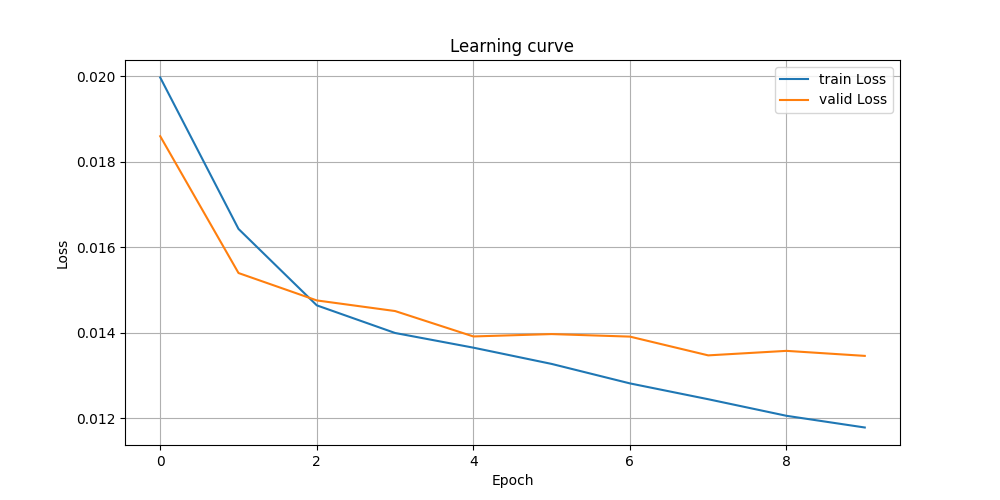

In [119]:
model_k3 = train(
    lr = lr,
    wd = wd,
    num_epochs=num_epochs,
    model = Model(
        kernel_size=3, 
        num_layers=4, 
        steps=1, 
        lin_steps=1, 
        dropout=0.1, 
        out_features=features,
        postfix="k3",
        training_args={
            "optimizer": {
                "name": "Adam",
                "lr": lr,
                "weight_decay": wd,
            },
            "batch_size": batch_size,
            "num_epochs": num_epochs,
        }
    ), 
    results=results,
    clear=True,
)



Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  9, Train Loss: 0.011431, Valid Loss: 0.012842, AUROC: 0.993780, Accuracy: 0.972574, Precision: 0.957338, Recall: 0.954082, F1: 0.955706, Harmonic: 0.872767, Eval: 0.140074, Time: 4.696058,  Best model -> saved to saved_models_2_balanced_aug/Model_F3k23_955.pthNew best F1: 0.9557064830413942 from 0


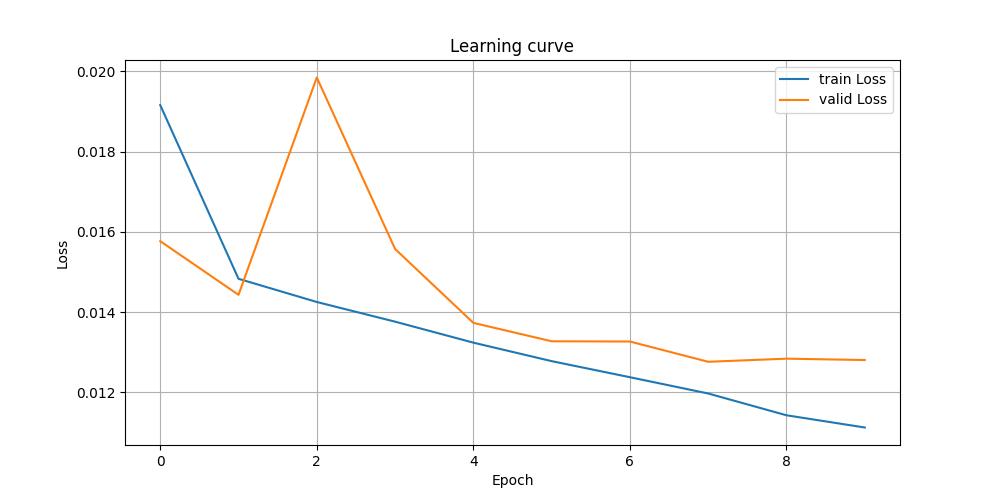

In [120]:
model_k23 = train(
    lr = lr,
    wd = wd,
    num_epochs=num_epochs,
    model = Model(
        kernel_size=23, 
        num_layers=4, 
        steps=1, 
        lin_steps=1, 
        dropout=0.1, 
        out_features=features,
        postfix="k23",
        training_args={
            "optimizer": {
                "name": "Adam",
                "lr": lr,
                "weight_decay": wd,
            },
            "batch_size": batch_size,
            "num_epochs": num_epochs,
        }
    ), 
    results=results,
    clear=True,
)

Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  9, Train Loss: 0.011846, Valid Loss: 0.012740, AUROC: 0.993282, Accuracy: 0.972574, Precision: 0.957338, Recall: 0.954082, F1: 0.955706, Harmonic: 0.872420, Eval: 0.140320, Time: 5.603026,  Best model -> saved to saved_models_2_balanced_aug/Model_F3k43_955.pthNew best F1: 0.9557064830413942 from 0


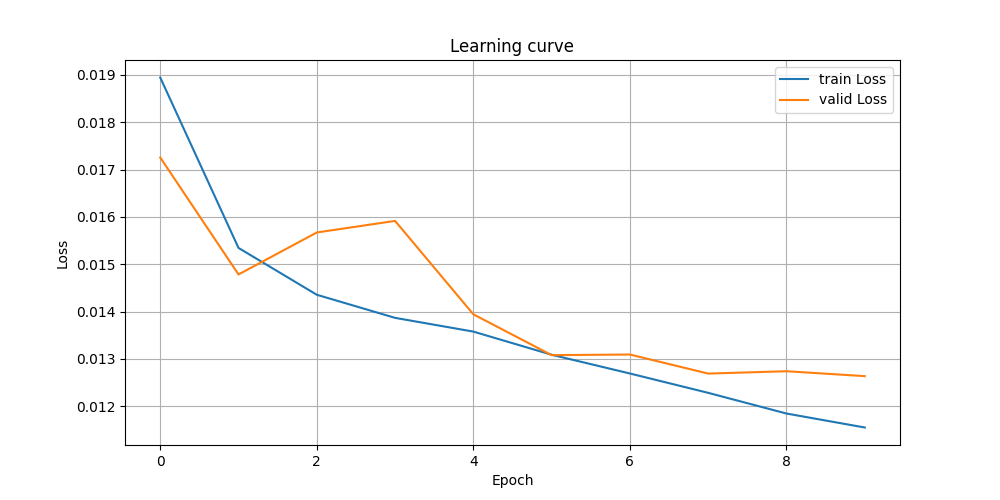

In [121]:
model_k43 = train(
    lr = lr,
    wd = wd,
    num_epochs=num_epochs,
    model = Model(
        kernel_size=43, 
        num_layers=4, 
        steps=1, 
        lin_steps=1, 
        dropout=0.1, 
        out_features=features,
        postfix="k43",
        training_args={
            "optimizer": {
                "name": "Adam",
                "lr": lr,
                "weight_decay": wd,
            },
            "batch_size": batch_size,
            "num_epochs": num_epochs,
        }
    ), 
    results=results,
    clear=True,
)

Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 10, Train Loss: 0.012493, Valid Loss: 0.013787, AUROC: 0.988174, Accuracy: 0.960970, Precision: 0.924092, Recall: 0.952381, F1: 0.938023, Harmonic: 0.822837, Eval: 0.190949, Time: 3.389664,  Best model -> saved to saved_models_2_balanced_aug/Model_V2_F3k3_938.pthNew best F1: 0.9380229491289359 from 0


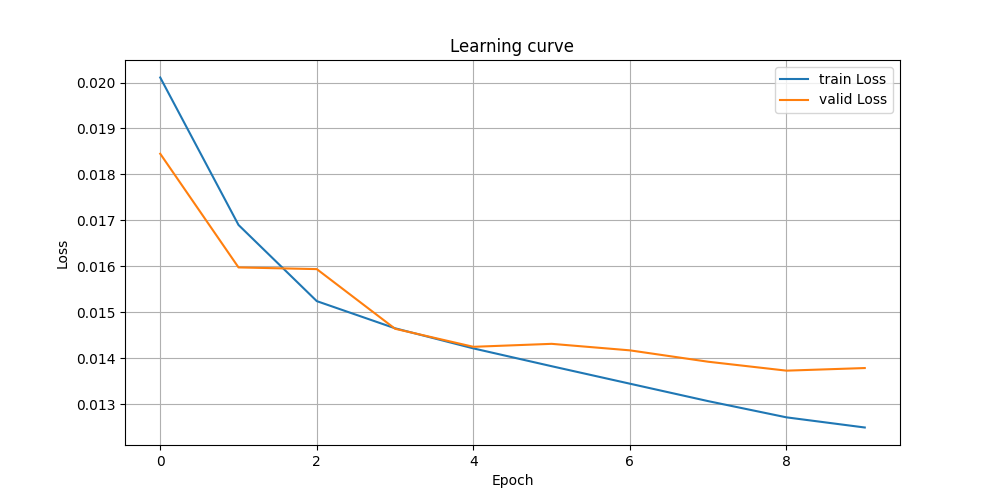

In [122]:
model_v2_k3 = train(
    lr=lr,
    wd=wd,
    num_epochs=num_epochs,
    model=Model_V2(
                kernel_size=3, 
                encode_layers=4,
                encoder_out_channels=64,
                reduce_layers=2,
                reduce_out_channels=1,
                steps=1, 
                dropout=0.05, 
                lin_steps=1, 
                lin_dims=64, 
                out_features=features,
                postfix="k3",
                training_args={
                    "optimizer": {
                        "name": "Adam",
                        "lr": lr,
                        "weight_decay": wd,
                    },
                    "batch_size": batch_size,
                    "num_epochs": num_epochs,
                }
            ), 
            results=results,
            clear=True,
    )


Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  7, Train Loss: 0.012452, Valid Loss: 0.013153, AUROC: 0.992234, Accuracy: 0.967827, Precision: 0.941374, Recall: 0.955782, F1: 0.948523, Harmonic: 0.852689, Eval: 0.160464, Time: 3.932518,  Best model -> saved to saved_models_2_balanced_aug/Model_V2_F3k23_948.pthNew best F1: 0.948522705179277 from 0


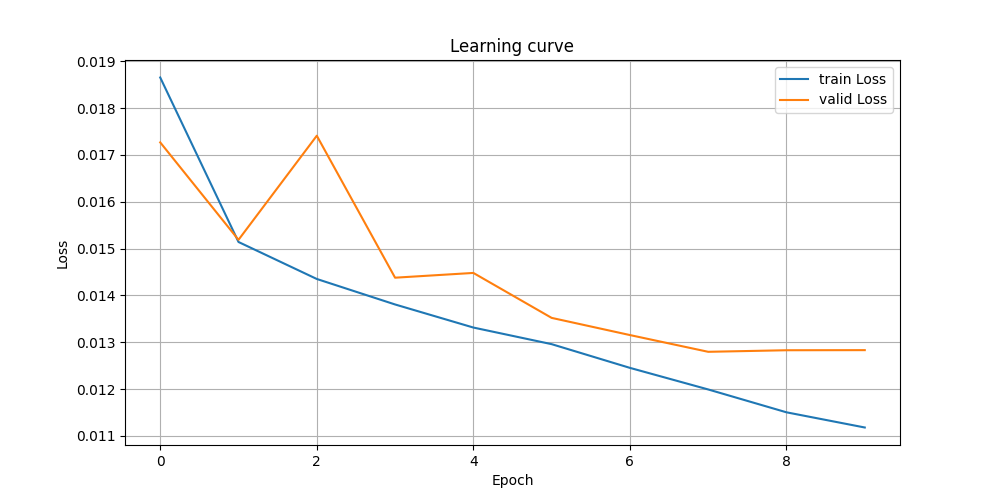

In [123]:
model_v2_k23 = train(
    lr=lr,
    wd=wd,
    num_epochs=num_epochs,
    model=Model_V2(
                kernel_size=23, 
                encode_layers=4,
                encoder_out_channels=64,
                reduce_layers=2,
                reduce_out_channels=1,
                steps=1, 
                dropout=0.05, 
                lin_steps=1, 
                lin_dims=64, 
                out_features=features,
                postfix="k23",
                training_args={
                    "optimizer": {
                        "name": "Adam",
                        "lr": lr,
                        "weight_decay": wd,
                    },
                    "batch_size": batch_size,
                    "num_epochs": num_epochs,
                }
            ), 
            results=results,
    )

Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  9, Train Loss: 0.011897, Valid Loss: 0.012871, AUROC: 0.991761, Accuracy: 0.969409, Precision: 0.960069, Recall: 0.940476, F1: 0.950171, Harmonic: 0.857080, Eval: 0.155792, Time: 5.322391,  Best model -> saved to saved_models_2_balanced_aug/Model_V2_F3k43_950.pthNew best F1: 0.950171319726648 from 0


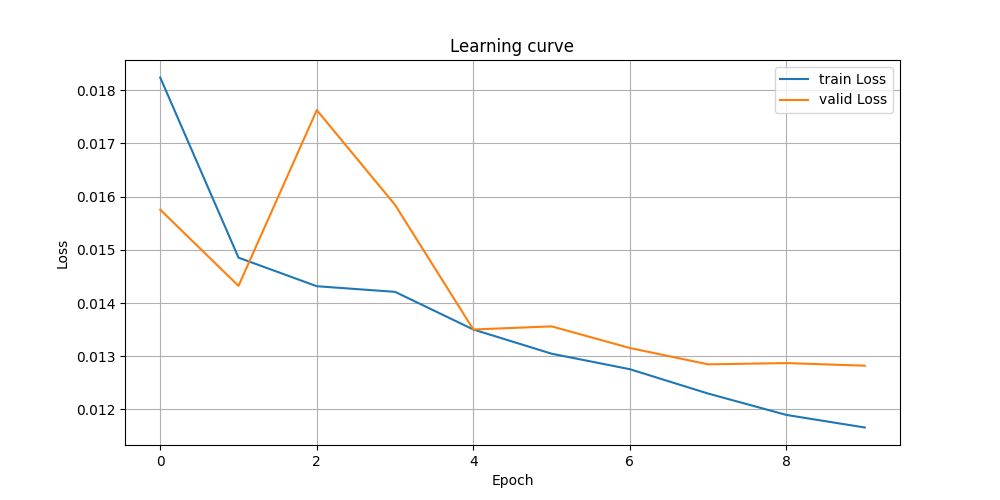

In [124]:
model_v2_k43 = train(
    lr=lr,
    wd=wd,
    num_epochs=num_epochs,
    model=Model_V2(
                kernel_size=43, 
                encode_layers=4,
                encoder_out_channels=64,
                reduce_layers=2,
                reduce_out_channels=1,
                steps=1, 
                dropout=0.05, 
                lin_steps=1, 
                lin_dims=64, 
                out_features=features,
                postfix="k43",
                training_args={
                    "optimizer": {
                        "name": "Adam",
                        "lr": lr,
                        "weight_decay": wd,
                    },
                    "batch_size": batch_size,
                    "num_epochs": num_epochs,
                }
            ), 
            results=results,
            clear=True,
    )


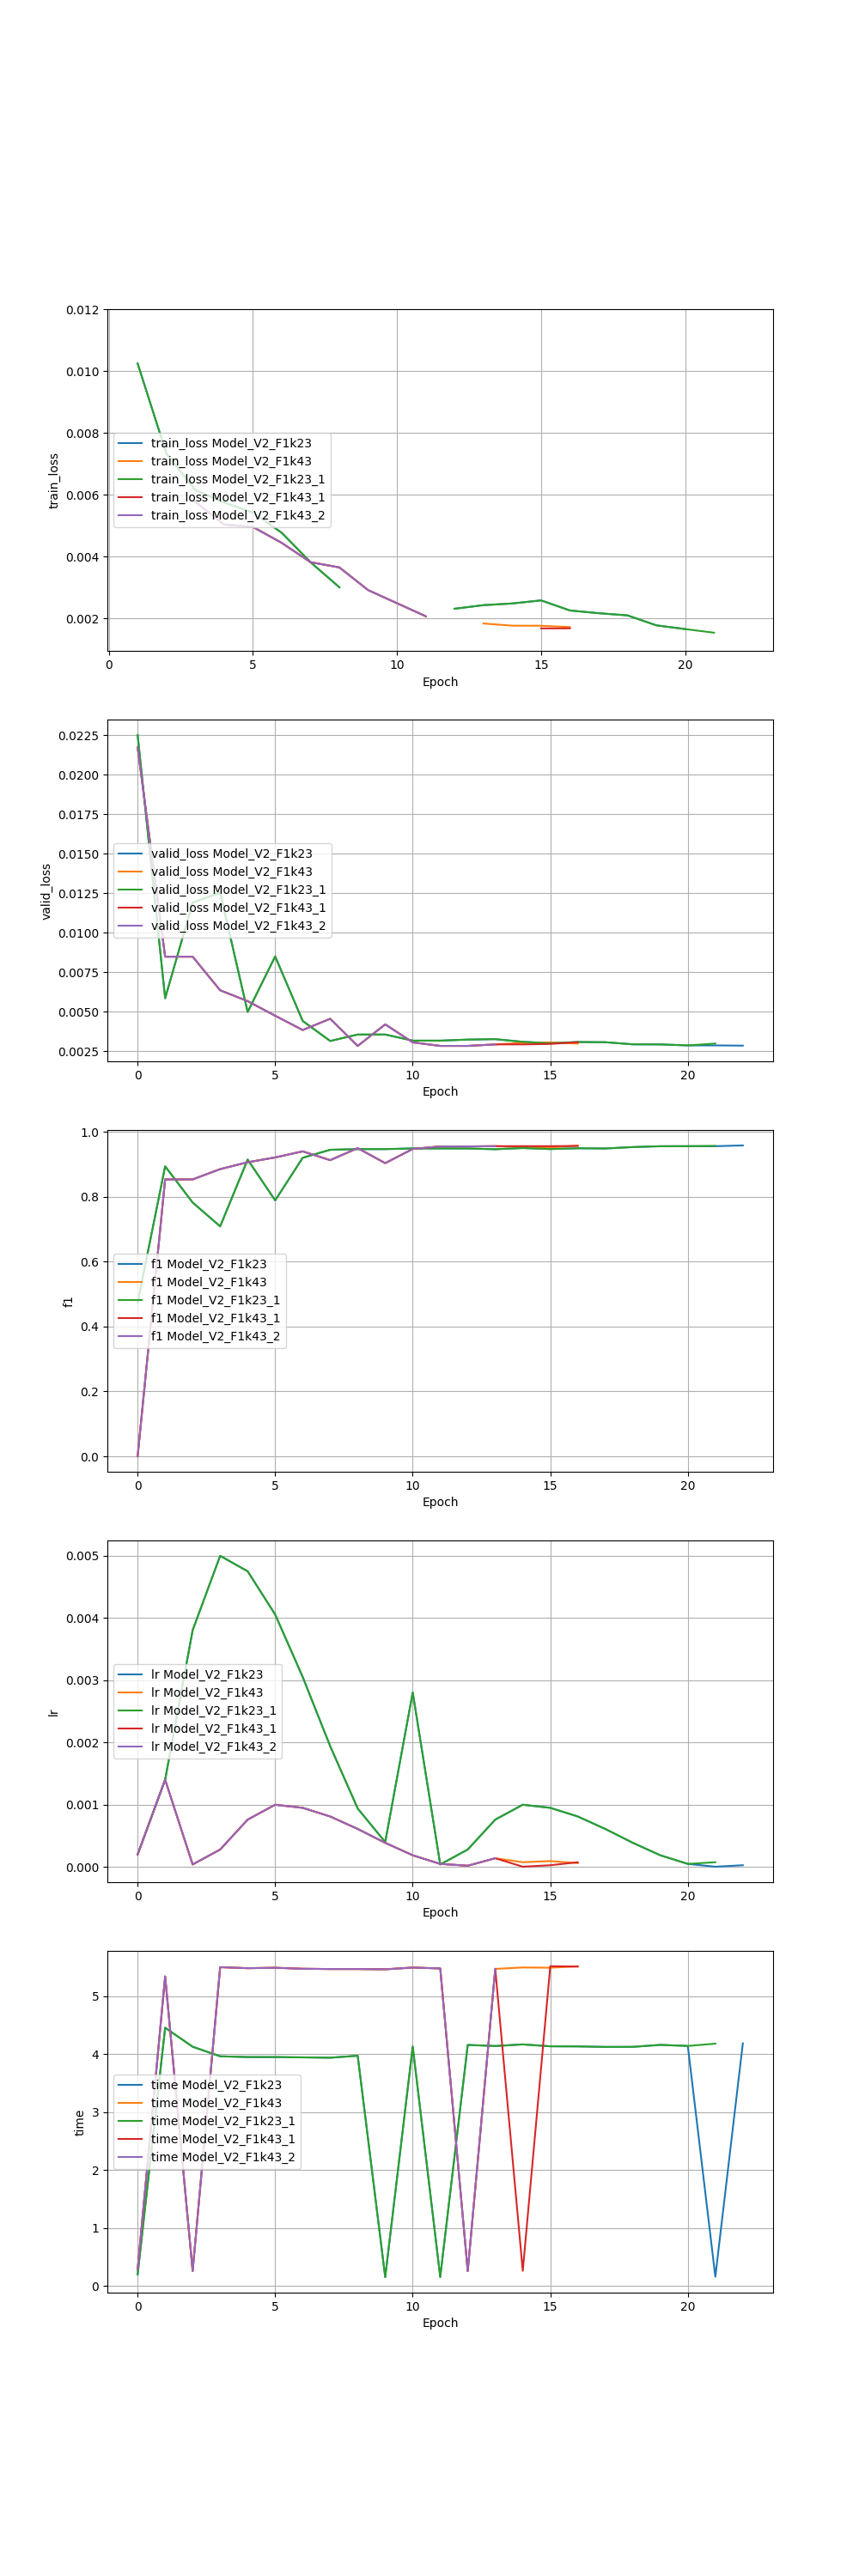

In [85]:
model_ckpts = list(filter(lambda x: x.split("_")[-1].split(".")[0].isnumeric(),  glob.glob(f'saved_models{data_blend}/*.pth')))

bests_ckpts = sorted(model_ckpts, key=lambda x: int(x.split("_")[-1].split(".")[0]), reverse=True)[:5]
disc_results = {}
for ckpt in bests_ckpts:
    ckpt = torch.load(ckpt)
    kvargs = ckpt['kvargs']
    name = kvargs["name"]
    eval = ckpt['eval']
    count = 1
    new_name = name
    while new_name in disc_results:
        new_name = f"{name}_{count}"
        count += 1
    disc_results[new_name] = eval

plot_labels = ['train_loss', 'valid_loss', 'f1', 'lr', 'time']
fig, ax = plt.subplots(len(plot_labels), 1, figsize=(10, 30))

for i, label in enumerate(plot_labels):
    for name, result in disc_results.items():
        # if 'Baseline' in name: # skip baseline
        #     continue
        ax[i].plot(result[label], label=f'{label} {name}') # skip first epochs
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel(label)
    # set label to the left 
    ax[i].legend(loc='center left')
    ax[i].grid()
plt.show()


In [48]:
# extra_epochs=10
# for model in tqdm([model_bl, model_k3, model_k23, model_k43, model_v2_k3, model_v2_k23, model_v2_k43]):
#     print(f'Training {model["model"].name} for {extra_epochs} extra epochs')
#     model = train(extra_epochs, **model, verbose=False)


In [125]:
from IPython.display import clear_output

extra_epochs=10
wd = 1e-4
for i in range(10):
    print(f"Run {i+1}/{10}")
    for lr in [1e-3, 5e-4, 1e-4]:
        print(f"Learning rate: {lr:.1e}")
        for features in [1, 3]:
            for model_prefix in [f"Model_F{features}k3", f"Model_F{features}k23", f"Model_F{features}k43", f"Model_V2_F{features}k3", f"Model_V2_F{features}k23", f"Model_V2_F{features}k43"]:
                load_and_train(data_blend, lr, wd, extra_epochs, results, model_prefix=model_prefix, top=5, verbose=False)
    # Clear the output
    clear_output(wait=True)

Run 1/10
Learning rate: 1.0e-03

saved_models_2_balanced_aug/Model_F3k3_937.pth
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 10, Train Loss: 0.010852, Valid Loss: 0.012884, AUROC: 0.991261, Accuracy: 0.966772, Precision: 0.939698, Recall: 0.954082, F1: 0.946835, Harmonic: 0.847640, Eval: 0.165244, Time: 4.245558,  Best model -> saved to saved_models_2_balanced_aug/Model_F3k3_946.pth
saved_models_2_balanced_aug/Model_F3k23_934.pth
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 10, Train Loss: 0.010996, Valid Loss: 0.012656, AUROC: 0.994276, Accuracy: 0.974684, Precision: 0.957627, Recall: 0.960884, F1: 0.959252, Harmonic: 0.882455, Eval: 0.130201, Time: 5.029449,  Best model -> saved to saved_models_2_balanced_aug/Model_F3k23_959.pth
saved_models_2_balanced_aug/Model_F3k43_943.pth
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  1, Train Loss: 0.012080, Valid Loss: 0.013137, AUROC: 0.992062, Accuracy: 0.967300, Precision: 0.938333, Recall: 0.957483, F1: 0.947811, Harmonic: 0.850684, Eval: 0.162454, Time: 6.065349,  Best model -> saved to saved_models_2_balanced_aug/Model_F3k43_947.pth
saved_models_2_balanced_aug/Model_V2_F3k3_931.pth
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  6, Train Loss: 0.013052, Valid Loss: 0.013736, AUROC: 0.987978, Accuracy: 0.965717, Precision: 0.942470, Recall: 0.947279, F1: 0.944868, Harmonic: 0.840430, Eval: 0.173306, Time: 3.567915,  Best model -> saved to saved_models_2_balanced_aug/Model_V2_F3k3_944.pth
saved_models_2_balanced_aug/Model_V2_F3k23_922.pth
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  7, Train Loss: 0.012300, Valid Loss: 0.013179, AUROC: 0.991964, Accuracy: 0.968354, Precision: 0.944444, Recall: 0.954082, F1: 0.949238, Harmonic: 0.854408, Eval: 0.158771, Time: 4.172694,  Best model -> saved to saved_models_2_balanced_aug/Model_V2_F3k23_949.pth
saved_models_2_balanced_aug/Model_V2_F3k43_928.pth
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  8, Train Loss: 0.011789, Valid Loss: 0.012591, AUROC: 0.991943, Accuracy: 0.969409, Precision: 0.949153, Recall: 0.952381, F1: 0.950764, Harmonic: 0.858438, Eval: 0.154153, Time: 5.536816,  Best model -> saved to saved_models_2_balanced_aug/Model_V2_F3k43_950.pthLearning rate: 5.0e-04

saved_models_2_balanced_aug/Model_F3k3_942.pth
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  1, Train Loss: 0.011338, Valid Loss: 0.013095, AUROC: 0.990423, Accuracy: 0.966245, Precision: 0.953287, Recall: 0.937075, F1: 0.945111, Harmonic: 0.843003, Eval: 0.170092, Time: 4.235258,  Best model -> saved to saved_models_2_balanced_aug/Model_F3k3_945.pth
saved_models_2_balanced_aug/Model_F3k23_953.pth
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  9, Train Loss: 0.010514, Valid Loss: 0.012512, AUROC: 0.993939, Accuracy: 0.975738, Precision: 0.959322, Recall: 0.962585, F1: 0.960950, Harmonic: 0.886745, Eval: 0.125767, Time: 4.717877,  Best model -> saved to saved_models_2_balanced_aug/Model_F3k23_960.pth
saved_models_2_balanced_aug/Model_F3k43_947.pth
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  7, Train Loss: 0.011579, Valid Loss: 0.012575, AUROC: 0.993021, Accuracy: 0.970992, Precision: 0.961872, Recall: 0.943878, F1: 0.952789, Harmonic: 0.864762, Eval: 0.147813, Time: 6.248439,  Best model -> saved to saved_models_2_balanced_aug/Model_F3k43_952.pth
saved_models_2_balanced_aug/Model_V2_F3k3_936.pth
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  2, Train Loss: 0.012926, Valid Loss: 0.014156, AUROC: 0.985687, Accuracy: 0.960970, Precision: 0.926910, Recall: 0.948980, F1: 0.937815, Harmonic: 0.820712, Eval: 0.193445, Time: 3.583144,  Best model -> saved to saved_models_2_balanced_aug/Model_V2_F3k3_937.pth

In [93]:
#finetune
from IPython.display import clear_output

extra_epochs=10
wd = 1e-4
for i in range(10):
    print(f"Run {i+1}/{10}")
    for lr in [1e-4, 5e-5, 1e-5]:
        print(f"Learning rate: {lr:.1e}")
        for features in [1, 3]:
            for model_prefix in [f"Model_F{features}k3", f"Model_F{features}k23", f"Model_F{features}k43", f"Model_V2_F{features}k3", f"Model_V2_F{features}k23", f"Model_V2_F{features}k43"]:
                load_and_train(data_blend, lr, wd, extra_epochs, results, model_prefix=model_prefix, top=1, verbose=False, keep_all=True)
    # Clear the output
    clear_output(wait=True)

Run 2/10
Learning rate: 1.0e-04

saved_models_2_balanced_aug/Model_F1k23_949.pth
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  1, Train Loss: 0.002874, Valid Loss: 0.003653, AUROC: 0.987926, Accuracy: 0.968354, Precision: 0.938538, Recall: 0.960884, F1: 0.949579, Harmonic: 0.852440, Eval: 0.151212, Time: 4.699155,  Best model -> saved to saved_models_2_balanced_aug/Model_F1k23_949.pth
saved_models_2_balanced_aug/Model_F1k43_955.pth
Training...


  0%|          | 0/10 [00:00<?, ?it/s]


saved_models_2_balanced_aug/Model_V2_F1k23_958.pth
Training...


  0%|          | 0/10 [00:00<?, ?it/s]


saved_models_2_balanced_aug/Model_V2_F1k43_960.pth
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  2, Train Loss: 0.001351, Valid Loss: 0.002876, AUROC: 0.992114, Accuracy: 0.975738, Precision: 0.964041, Recall: 0.957483, F1: 0.960750, Harmonic: 0.885011, Eval: 0.117865, Time: 5.498088,  Best model -> saved to saved_models_2_balanced_aug/Model_V2_F1k43_960.pthLearning rate: 5.0e-05

saved_models_2_balanced_aug/Model_F1k23_949.pth
Training...


  0%|          | 0/10 [00:00<?, ?it/s]


saved_models_2_balanced_aug/Model_F1k43_955.pth
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:  3, Train Loss: 0.002362, Valid Loss: 0.002890, AUROC: 0.990743, Accuracy: 0.972574, Precision: 0.952703, Recall: 0.959184, F1: 0.955932, Harmonic: 0.871145, Eval: 0.131745, Time: 5.622389,  Best model -> saved to saved_models_2_balanced_aug/Model_F1k43_955.pth
saved_models_2_balanced_aug/Model_V2_F1k23_958.pth
Training...


  0%|          | 0/10 [00:00<?, ?it/s]


saved_models_2_balanced_aug/Model_V2_F1k43_960.pth
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [94]:
model_ckpts = glob.glob(f'saved_models{data_blend}/*.pth')
model_ckpts = glob.glob(f'saved_models_standard/*.pth')

ckpts = [torch.load(ckpt, map_location=torch.device('cpu')) for ckpt in model_ckpts]

sorted_ckpts = sorted(ckpts, key=lambda x: x['f1'], reverse=True)
for ckpt in sorted_ckpts:
    name = ckpt['kvargs']['name']
    # print(f"{name:11} - f1 {ckpt['f1']:.3f}, epochs {len(ckpt['eval']['train_loss'])}")
    print(f"{name:11} - f1 {ckpt['f1']:.3f}")

Model       - f1 0.962
Model       - f1 0.961
Model       - f1 0.961
Model_V2    - f1 0.960
Model       - f1 0.960
Model_F1_V2 - f1 0.959
Model_V2    - f1 0.959
Model_V2    - f1 0.958
Model_V2    - f1 0.958
Model_F1_V2 - f1 0.957
Model_F1    - f1 0.956
Model_F1_V2 - f1 0.955
Model_F1    - f1 0.955
Model_F1_V2 - f1 0.954
Model_F1    - f1 0.953
Model_F1    - f1 0.950
Baseline_F1 - f1 0.616
Baseline_F1 - f1 0.610
Baseline_F1 - f1 0.605
Baseline_F1 - f1 0.600


In [95]:
import legacy_models as lm
top = 20
NAME_2_MODEL = {
    'Baseline': Baseline,
    'Model_F1_V2': Model_V2,
    'Model_F3_V2': Model_V2,
    'Model_F': Model,
    'Model_F': Model,
    'Model_V2_F': Model_V2,
    'Model_V2': lm.Model_V2,
    'Model': lm.Model,
}


scored_models= []
for index, ckpt in enumerate(tqdm(sorted_ckpts[:top])):
    if ckpt['f1'] < 0.94:
        continue
    kvargs = ckpt['kvargs']
    name = kvargs["name"]
    for name_type, model in NAME_2_MODEL.items():
      if name_type in name:
        eval_model = model(**kvargs)
        break
    try:
        eval_model.load_state_dict(ckpt['model'])
    except:
        print(f"Error loading {name}")
        continue
    eval_model.eval()

    # print(f"{index} | {name} -  Score: {ckpt['score']:.3}, sF1: {ckpt['f1']:.3}, F1: {f1_eval:.3} , Eval loss: {valid_loss_eval:.3}, AUROC: {auroc_eval:.3}, Accuracy: {accuracy_eval:.3}, Precision: {precision_eval:.3}, Recall: {recall_eval:.3}")

    scored_models.append((eval_model, ckpt['f1']))
print("Best models:")
scored_models = sorted(scored_models, key=lambda x: x[1], reverse=True)
for index, (model, f1) in enumerate(scored_models):
    print(f"{index:3} | {model.name:11} - F1: {f1:.3f}")

  0%|          | 0/20 [00:00<?, ?it/s]

Best models:
  0 | Model       - F1: 0.962
  1 | Model       - F1: 0.961
  2 | Model       - F1: 0.961
  3 | Model_V2    - F1: 0.960
  4 | Model       - F1: 0.960
  5 | Model_V2_F1 - F1: 0.959
  6 | Model_V2    - F1: 0.959
  7 | Model_V2    - F1: 0.958
  8 | Model_V2    - F1: 0.958
  9 | Model_V2_F1 - F1: 0.957
 10 | Model_F1    - F1: 0.956
 11 | Model_V2_F1 - F1: 0.955
 12 | Model_F1    - F1: 0.955
 13 | Model_V2_F1 - F1: 0.954
 14 | Model_F1    - F1: 0.953
 15 | Model_F1    - F1: 0.950


In [96]:
ckpt = scored_models[0] 
eval_model = ckpt[0]
print(f"Selected model: {eval_model.name}")

Selected model: Model


---
## Model Testing

Since we saved our best model, we can now load the trained model and make predictions on the test data set. We save the predictions in a csv file which will be uploaded as part of the deliverables. Note that we take a `Sigmoid()` function on the model prediction in order to obtain hard predction (0,1) instead of soft predictions (probabilities). 

### Coding Task 7: Make prediction for test data

Here you do not really need to code but you have to:
- replace the baseline model with your model. If you do not use colab then change the path to the model location to load the trained model)
- run the script. The soft and hard predictions are saved in the variables `soft_pred` and `hard_pred`.
- upload your predictions to the leaderboard online (see instruction details below). 

In [97]:
# build the dataloader once and re-use when running the cell below possibly multiple times.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# =============== Build data loaders ==========================================#
tqdm.write("Building data loaders...")
# load data
path_to_h5_test, path_to_csv_test = 'codesubset/test.h5', 'codesubset/test.csv'
traces = torch.tensor(h5py.File(path_to_h5_test, 'r')['tracings'][()], dtype=torch.float32)
dataset = TensorDataset(traces)
len_dataset = len(dataset)
# build data loaders
test_dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
tqdm.write("Done!\n")

Building data loaders...
Done!



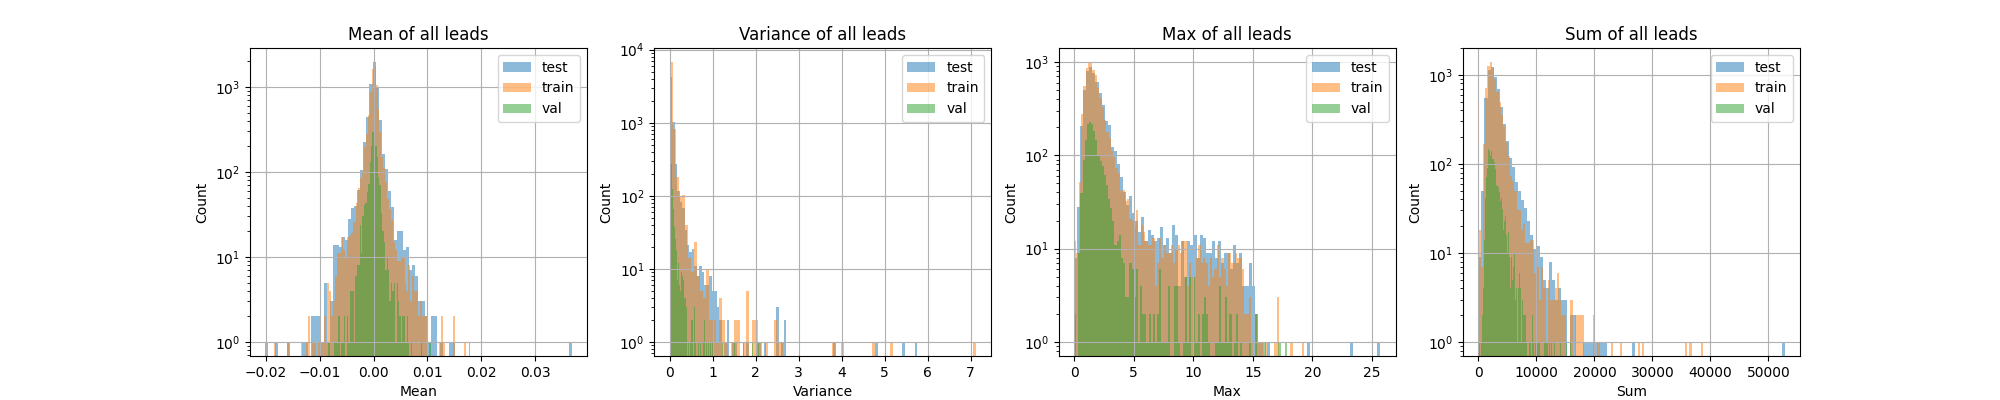

In [98]:
test_data = traces.cpu().numpy()
test_means = np.mean(test_data, axis=(1, 2))
uniq_train_index = np.unique(train_index)
train_data = np.mean(data[uniq_train_index], axis=(1, 2))
uniq_val_index = np.unique(val_index)
val_data = np.mean(data[uniq_val_index], axis=(1, 2))

fig, ax = plt.subplots(1, 4, figsize=(20, 4))

ax[0].hist(test_means, bins=100, log=True, label='test', alpha = 0.5)
ax[0].hist(train_data, bins=100, log=True, label='train', alpha = 0.5)
ax[0].hist(val_data, bins=100, log=True, label='val', alpha = 0.5)
ax[0].set_title('Mean of all leads')
ax[0].set_xlabel('Mean')    
ax[0].set_ylabel('Count')
ax[0].grid(True)
ax[0].legend()

test_variances = np.var(test_data, axis=(1, 2))
train_variances = np.var(data[uniq_train_index], axis=(1, 2))
val_variances = np.var(data[uniq_val_index], axis=(1, 2))

ax[1].hist(test_variances, bins=100, log=True, label='test', alpha = 0.5)
ax[1].hist(train_variances, bins=100, log=True, label='train', alpha = 0.5)
ax[1].hist(val_variances, bins=100, log=True, label='val', alpha = 0.5)
ax[1].set_title('Variance of all leads')
ax[1].set_xlabel('Variance')
ax[1].set_ylabel('Count')
ax[1].grid(True)
ax[1].legend()

test_maxs = np.max(test_data, axis=(1, 2))
train_maxs = np.max(data[uniq_train_index], axis=(1, 2))
val_maxs = np.max(data[uniq_val_index], axis=(1, 2))

ax[2].hist(test_maxs, bins=100, log=True, label='test', alpha = 0.5)
ax[2].hist(train_maxs, bins=100, log=True, label='train', alpha = 0.5)
ax[2].hist(val_maxs, bins=100, log=True, label='val', alpha = 0.5)
ax[2].set_title('Max of all leads')
ax[2].set_xlabel('Max')
ax[2].set_ylabel('Count')
ax[2].grid(True)
ax[2].legend()

test_sums = np.sum(np.abs(test_data), axis=(1, 2))
train_sums = np.sum(np.abs(data[uniq_train_index]), axis=(1, 2))
val_sums = np.sum(np.abs(data[uniq_val_index]), axis=(1, 2))

ax[3].hist(test_sums, bins=100, log=True, label='test', alpha = 0.5)
ax[3].hist(train_sums, bins=100, log=True, label='train', alpha = 0.5)
ax[3].hist(val_sums, bins=100, log=True, label='val', alpha = 0.5)
ax[3].set_title('Sum of all leads')
ax[3].set_xlabel('Sum')
ax[3].set_ylabel('Count')
ax[3].grid(True)
ax[3].legend()

In [99]:
# create a dataframe for the test data with the predicted af sex and age 
def f3_to_df(model, data_loader, device):
    pred_meta = []
    model.eval()
    model.to(device)
    for x, *_ in data_loader:
        with torch.no_grad():
            x = x.to(device)
            y_pred = model(x)
            y_pred = y_pred.cpu().numpy()
            af = y_pred[:, 0] > 0.5
            sex = y_pred[:, 1] > 0.5
            sex = np.where(sex, 'M', 'F')
            age = y_pred[:, 2] * 100
            age = np.where(age < 0, 0, age)
            age = np.where(age > 100, 101, age)

            pred_meta += list(zip(af, sex, age))
    #convert to pandas dataframe
    pred_meta = pd.DataFrame(pred_meta, columns=['AF', 'sex', 'age'])
    return pred_meta

if eval_model.out_features == 3: 
    pred_meta_test = f3_to_df(eval_model, test_dataloader, device)
    pred_meta_val = f3_to_df(eval_model, valid_dataloader[1], device)

In [100]:
if eval_model.out_features == 3: 

    bar_width = 0.45

    base_meta_data = pd.read_csv('codesubset/train.csv')
    train_meta_data = base_meta_data.iloc[train_index]
    val_meta_data = base_meta_data.iloc[val_index]


    train_meta_data, x, age_labels, train_fc, train_mc, train_fs, train_ms = split_data_by_age_sex_af(train_meta_data)
    val_meta_data, _, _, val_fc, val_mc, val_fs, val_ms = split_data_by_age_sex_af(val_meta_data)
    pred_meta_val, _, _, pred_val_fc, pred_val_mc, pred_val_fs, pred_val_ms = split_data_by_age_sex_af(pred_meta_val)
    pred_meta_test, _, _, test_fc, test_mc, test_fs, test_ms = split_data_by_age_sex_af(pred_meta_test)

    # Plotting the grouped bar plot

    fig, ax = plt.subplots(5, 1, figsize=(20, 30))
    plot_age_range_sex_af(ax[0], x, age_labels, train_fc, train_mc, train_fs, train_ms,  prefix='Train data')
    plot_age_range_sex_af(ax[1], x, age_labels, val_fc, val_mc, val_fs, val_ms,  prefix='Val data')
    plot_age_range_sex_af(ax[2], x, age_labels, pred_val_fc, pred_val_mc, pred_val_fs, pred_val_ms,  prefix='Pred Val data')
    plot_age_range_sex_af(ax[3], x, age_labels, test_fc, test_mc, test_fs, test_ms,  prefix='Test data')


    # compute the precental of male and female with HA
    ax[4].bar(x - 3*bar_width,  train_ms / (train_ms + train_mc), width=bar_width, label='Train Male AF %', color='blue')
    ax[4].bar(x - 2*bar_width,  val_ms / (val_ms + val_mc), width=bar_width, label='Val Male AF %', color='lightblue')
    ax[4].bar(x - bar_width,  pred_val_ms / (pred_val_ms + pred_val_mc), width=bar_width, label='Pred Val Male AF %', color='green')
    ax[4].bar(x,  test_ms / (test_ms + test_mc), width=bar_width, label='Pred Test Male AF %', color='lightgreen')
    ax[4].bar(x + bar_width, train_fs / (train_fs + train_fc), width=bar_width, label='Train Female AF %', color='red')
    ax[4].bar(x + 2*bar_width,  val_ms / (val_ms + val_mc), width=bar_width, label='Val Female AF %', color='lightcoral')
    ax[4].bar(x + 3*bar_width,  pred_val_ms / (pred_val_ms + pred_val_mc), width=bar_width, label='Pred Val Female AF %', color='gold')
    ax[4].bar(x + 4*bar_width, test_fs / (test_fs + test_fc), width=bar_width, label='Pred Test Female AF %', color='yellow')


    ax[0].set_title(f'Percentile of Cases by Age, Sex, Age Range, that have positive AF')
    ax[4].set_xlabel(f'Age Range')
    ax[4].set_ylabel('Percentile of Cases')
    ax[4].set_xticks(x  + bar_width / 2)
    ax[4].set_xticklabels(age_labels)
    ax[4].tick_params(labelsize=8)
    ax[4].legend()
    ax[4].grid(True)

    plt.show()

In [101]:
if eval_model.out_features == 3: 
    fig, ax = plt.subplots(3, 4, figsize=(20, 15))
    val_meta_data["sex"].groupby(val_meta_data["sex"]).count().plot(kind="bar", ax=ax[0, 0], alpha=0.5, label="Val Sex", color="blue") 
    pred_meta_val["sex"].groupby(pred_meta_val["sex"]).count().plot(kind="bar", ax=ax[0, 1], alpha=0.5, label="Pred Val Sex", color="orange") 
    pred_meta_test["sex"].groupby(pred_meta_test["sex"]).count().plot(kind="bar", ax=ax[0, 2], alpha=0.5, label="Pred Test Sex", color="red")
    train_meta_data["sex"].groupby(train_meta_data["sex"]).count().plot(kind="bar", ax=ax[0, 3], alpha=0.5, label="Train Sex", color="green")
    

    val_meta_data["AF"].groupby(val_meta_data["AF"]).count().plot(kind="bar", ax=ax[1, 0], alpha=0.5, label="Val AF", color="blue")
    pred_meta_val["AF"].groupby(pred_meta_val["AF"]).count().plot(kind="bar", ax=ax[1, 1], alpha=0.5, label="Pred Val AF", color="orange")
    pred_meta_test["AF"].groupby(pred_meta_test["AF"]).count().plot(kind="bar", ax=ax[1, 2], alpha=0.5, label="Pred Test AF", color="red")
    train_meta_data["AF"].groupby(train_meta_data["AF"]).count().plot(kind="bar", ax=ax[1, 3], alpha=0.5, label="Train AF", color="green")

    #how many cases in each age range
    val_meta_data["age_range"].groupby(val_meta_data["age_range"]).count().plot(kind="bar", ax=ax[2, 0], alpha=0.5, label="Val Age Range", color="blue")
    pred_meta_val["age_range"].groupby(pred_meta_val["age_range"]).count().plot(kind="bar", ax=ax[2, 1], alpha=0.5, label="Pred Val Age Range", color="orange")
    pred_meta_test["age_range"].groupby(pred_meta_test["age_range"]).count().plot(kind="bar", ax=ax[2, 2], alpha=0.5, label="Pred Test Age Range", color="red")
    train_meta_data["age_range"].groupby(train_meta_data["age_range"]).count().plot(kind="bar", ax=ax[2, 3], alpha=0.5, label="Train Age Range", color="green")

    for a in ax:
        for b in a:
            b.legend()
            b.grid(True)
    plt.show()

In [102]:
def plot_ecg(preds, vars, indexs, names):
    @widgets.interact(
                    case=widgets.IntSlider(min=0, max=len(test_data)-1, step=1, value=0, disabled=False, continuous_update=False, ),
                    )
    def ecg_data_plot(case):
        data = test_data[indexs[case]]
        print(f"Case {indexs[case]}, var {vars[indexs[case]]}")
        for name, score in sorted(zip(names, preds[indexs[case]]), key=lambda x: x[0], reverse=True):
            print(name, round(score, 3))
        ecg_plot.plot(data.transpose(1, 0), sample_rate=sample_rate, style='bw', lead_index=lead, row_height=8)
        plt.show()

In [103]:
soft_preds = []
valid_preds = []
valid_labels = torch.zeros(len_dataset,1)
for index, (model, f1) in enumerate(tqdm(scored_models)):
    print(f"Model {model.name}")
    model.to(device=device)

    # =============== Evaluate model ==============================================#
    model.eval()
    # allocation
    test_pred = torch.zeros(len_dataset,1)
    valid_pred = torch.zeros(len_dataset,1)
    # progress bar def
    test_pbar = tqdm(test_dataloader, desc="Testing")
    # evaluation loop
    end=0
    for traces in test_pbar:
        # data to device
        traces = traces[0].to(device)
        start = end
        with torch.no_grad():
            # Forward pass
            model_output = model(traces)

            # store output
            end = min(start + len(model_output), test_pred.shape[0])
            if eval_model.out_features == 3: 
                test_pred[start:end] = torch.sigmoid(model_output[:,0]).unsqueeze(1).detach().cpu() # only take the first output
            else:
                test_pred[start:end] = torch.sigmoid(model_output).detach().cpu()
    val_end = 0
    for valid_data, valid_target in valid_dataloader[model.out_features]:
        valid_data = valid_data.to(device)
        valid_start = val_end
        with torch.no_grad():
            model_output = model(valid_data)
            val_end = min(valid_start + len(model_output), valid_pred.shape[0])
            if eval_model.out_features == 3: 
                valid_pred[valid_start:val_end] = torch.sigmoid(model_output[:,0]).unsqueeze(1).detach().cpu()
            else:
                valid_pred[valid_start:val_end] = torch.sigmoid(model_output).detach().cpu()
            valid_labels[valid_start:val_end] = valid_target.detach().cpu()



    # =============== Save predictions ============================================#
    soft_pred = np.stack((1-test_pred.numpy(), test_pred.numpy()),axis=1).squeeze()
    soft_preds.append((soft_pred, f1, index))
    valid_preds.append(valid_pred)
    model.to(device='cpu')
soft_preds = sorted(soft_preds, key=lambda x: x[1], reverse=True)
print(f"Number of models used: {len(soft_preds)}")
valid_labels = valid_labels.reshape(-1).numpy()

  0%|          | 0/16 [00:00<?, ?it/s]

Model Model


Testing:   0%|          | 0/188 [00:00<?, ?it/s]

Model Model


Testing:   0%|          | 0/188 [00:00<?, ?it/s]

Model Model


Testing:   0%|          | 0/188 [00:00<?, ?it/s]

Model Model_V2


Testing:   0%|          | 0/188 [00:00<?, ?it/s]

Model Model


Testing:   0%|          | 0/188 [00:00<?, ?it/s]

Model Model_V2_F1


Testing:   0%|          | 0/188 [00:00<?, ?it/s]

Model Model_V2


Testing:   0%|          | 0/188 [00:00<?, ?it/s]

Model Model_V2


Testing:   0%|          | 0/188 [00:00<?, ?it/s]

Model Model_V2


Testing:   0%|          | 0/188 [00:00<?, ?it/s]

Model Model_V2_F1


Testing:   0%|          | 0/188 [00:00<?, ?it/s]

Model Model_F1


Testing:   0%|          | 0/188 [00:00<?, ?it/s]

Model Model_V2_F1


Testing:   0%|          | 0/188 [00:00<?, ?it/s]

Model Model_F1


Testing:   0%|          | 0/188 [00:00<?, ?it/s]

Model Model_V2_F1


Testing:   0%|          | 0/188 [00:00<?, ?it/s]

Model Model_F1


Testing:   0%|          | 0/188 [00:00<?, ?it/s]

Model Model_F1


Testing:   0%|          | 0/188 [00:00<?, ?it/s]

Number of models used: 16


In [104]:
select = 0
best = 0
for i in range(1,len(valid_preds)):
    mean_valid_preds = np.mean(np.stack(valid_preds[:i]), axis=(0, 2))
    median_valid_preds = np.median(np.stack(valid_preds[:i]), axis=(0, 2))
    f1_mean = f1_score(valid_labels, mean_valid_preds)
    f1_median = f1_score(valid_labels, median_valid_preds)
    harm = max(f1_mean, f1_median)
    if harm > best:
        best = harm
        select = i
print("selected", select)
mean_valid_preds = np.mean(np.stack(valid_preds[:select]), axis=(0, 2))
median_valid_preds = np.median(np.stack(valid_preds[:select]), axis=(0, 2))

print("f1 mean  ",  round(f1_score(valid_labels, mean_valid_preds), 3))
print("f1 median",  round(f1_score(valid_labels, median_valid_preds), 3))
print()
print("accuracy mean  ",  round(accuracy_score(valid_labels, mean_valid_preds), 3))
print("accuracy median",  round(accuracy_score(valid_labels, median_valid_preds), 3))
print()
print("recall mean  ",  round(recall_score(valid_labels, mean_valid_preds), 3))
print("recall median",  round(recall_score(valid_labels, median_valid_preds), 3))
print()
print("precision mean  ",  round(precision_score(valid_labels, mean_valid_preds), 3))
print("precision median",  round(precision_score(valid_labels, median_valid_preds), 3))

print()
print("best model f1", scored_models[0][1])


selected 7
f1 mean   0.974
f1 median 0.974

accuracy mean   0.995
accuracy median 0.995

recall mean   0.973
recall median 0.973

precision mean   0.976
precision median 0.974

best model f1 0.9622839817590941


In [105]:
group_preds = np.array([pred[0][:, 0] for pred in soft_preds[:select]]).T
group_preds_var = np.var(group_preds, axis=1)
index_group_preds_var = np.argsort(group_preds_var)[::-1]
group_names =  [int(soft_pred[1]*1000) for soft_pred in soft_preds[:select]]
group_preds_var[index_group_preds_var]

array([1.9260439e-01, 1.8407910e-01, 1.8194516e-01, ..., 5.5828358e-14,
       2.0301222e-14, 1.7256038e-14], dtype=float32)

In [75]:
plot_ecg(group_preds, group_preds_var, index_group_preds_var, group_names)

interactive(children=(IntSlider(value=0, continuous_update=False, description='case', max=5999), Output()), _d…

In [106]:
ensemble_mean_preds = np.mean(group_preds.T, axis=0)
soft_pred_mean = np.stack((ensemble_mean_preds, 1-ensemble_mean_preds),axis=1).squeeze()

ensemble_median_preds = np.median(group_preds.T, axis=0)
soft_pred_median = np.stack((ensemble_median_preds, 1-ensemble_median_preds),axis=1).squeeze()

In [107]:
def center_data(data):
    selected = data[:, 0].copy()
    selected_sorted_index =  np.argsort(selected)[::-1]
    selected_sorted = selected[selected_sorted_index]
    selected -= selected_sorted[3000]
    # all values below 0 are normalized between 0 and -1
    selected[selected<0] = -selected[selected<0]/np.min(selected[selected<0])
    # all values above 0 are normalized between 0 and 1
    selected[selected>0] = selected[selected>0]/np.max(selected[selected>0])
    selected = selected/2+0.5
    selected_soft_pred = np.stack((selected, 1-selected),axis=1).squeeze()
    selected_soft_pred = np.clip(selected_soft_pred, 0, 1)
    return selected_soft_pred


/tmp/ipykernel_2504413/52574762.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1, figsize=(10, 10))


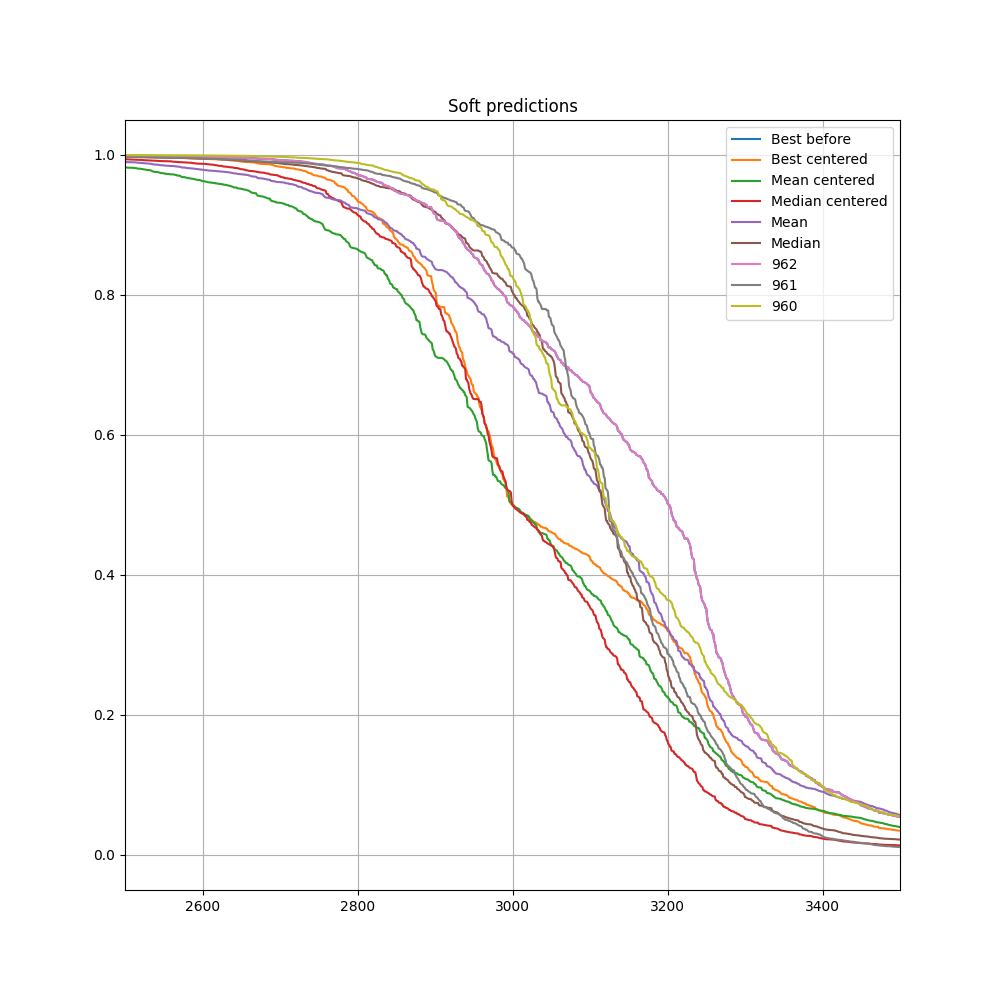

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
best_soft_pred = soft_preds[0][0]
selected = best_soft_pred[:, 0].copy()
selected_sorted_index =  np.argsort(selected)[::-1]
ax.plot(selected[selected_sorted_index], label="Best before")

centered_soft_pred = center_data(best_soft_pred)

selected = centered_soft_pred[:, 0].copy()
selected_sorted_index =  np.argsort(selected)[::-1]
ax.plot(selected[selected_sorted_index], label="Best centered")

center_mean_soft_pred = center_data(soft_pred_mean)
selected = center_mean_soft_pred[:, 0].copy()
selected_sorted_index =  np.argsort(selected)[::-1]
ax.plot(selected[selected_sorted_index], label="Mean centered")

center_median_soft_pred = center_data(soft_pred_median)
selected = center_median_soft_pred[:, 0].copy()
selected_sorted_index =  np.argsort(selected)[::-1]
ax.plot(selected[selected_sorted_index], label="Median centered")

selected_soft_pred = np.stack((selected, 1-selected),axis=1).squeeze()

for name, pred in [("Mean", soft_pred_mean), ("Median", soft_pred_median)]:
    if len(pred.shape) > 1:
        pred = pred[:, 0].copy()
    tmp = pred.copy()
    tmp_sorted_index =  np.argsort(tmp)[::-1]
    tmp_sorted = tmp[tmp_sorted_index]
    ax.plot(tmp_sorted, label=f"{name}")

for pred in soft_preds[:3]:
    soft_pred = pred[0]
    selected = soft_pred[:, 0].copy()
    selected_sorted_index =  np.argsort(selected)[::-1]
    selected_sorted = selected[selected_sorted_index]
    ax.plot(selected_sorted, label=f"{int(pred[1]*1000)}")



ax.set_title("Soft predictions")
ax.set_xlim(2500, 3500)
ax.legend()
ax.grid(True)
plt.show()


In [110]:
all_named_preds = [
    ("Best centered", centered_soft_pred),
    ("Mean centered", center_mean_soft_pred),
    ("Median centered", center_median_soft_pred),
    ("Mean", soft_pred_mean),
    ("Median", soft_pred_median),
    *[("Best " + str(i), p[0]) for i, p in enumerate(soft_preds)]

]

In [111]:
submissions = glob.glob("prediction_*.json")

submissions_data = [( submission.split(".")[0].split("_")[1], np.array(json.loads(Path(submission).read_text())["prediction"])) for submission in submissions ]

for name, pred in all_named_preds:
    print(name)
    afs = [pred[:,0]]
    scores = []
    names = [-1]
    for name, sd in submissions_data:
        name = int(name)
        if name > 900:
            afs.append(sd[:,0])
            names.append(name)
        scores.append((name,  np.abs(sd - pred).mean(), np.sum(sd[:,0]>0.5)/len(sd))) # sanity check that the predictions are reasonable
    print(f"curr split {np.sum(pred[:,0]>0.5)/len(pred):.3f}")
    print()
    for name, score, split in sorted(scores, key=lambda x: x[1]):
        if score < 0.01:
            print (f"{name:10} {score:.3f} {split:.3f} <---")
        else:
            print(f"{name:10} {score:.3f} {split:.3f}")


Best centered
curr split 0.500

       964 0.025 0.500
       965 0.025 0.500
       960 0.029 0.523
       961 0.031 0.500
       960 0.033 0.523
       960 0.036 0.500
       957 0.037 0.500
       957 0.038 0.521
       954 0.039 0.524
       951 0.039 0.526
       949 0.043 0.521
       604 0.344 0.710
         0 0.471 1.000
Mean centered
curr split 0.500

       964 0.013 0.500
       965 0.014 0.500
       960 0.023 0.523
       961 0.027 0.500
       957 0.028 0.500
       960 0.030 0.523
       957 0.032 0.521
       960 0.032 0.500
       951 0.035 0.526
       954 0.037 0.524
       949 0.037 0.521
       604 0.344 0.710
         0 0.469 1.000
Median centered
curr split 0.500

       964 0.009 0.500 <---
       965 0.009 0.500 <---
       960 0.019 0.523
       961 0.019 0.500
       957 0.024 0.500
       960 0.024 0.523
       960 0.027 0.500
       957 0.028 0.521
       954 0.031 0.524
       951 0.033 0.526
       949 0.036 0.521
       604 0.351 0.710
         0 0.478 1

In [112]:
soft_pred = best_soft_pred

To upload your predictions to the leaderboard, use the following code. There are the following steps to follow:
1. Download the GitHub repository for the leaderboard submission system.
2. Register your team with a **team id** and **password**. The password ensures that only your team can upload to your team id. Do only run the registration once.
3. Upload you predictions as a new submission. There are some things to obey here:
    - For each submission you have to attach a note for you to keep track of the submission in the leaderboard and for us to know which submission you refer to in your explanation. Choose something meaningful such as "submission A" or "model B".
    - You can only get one prediction evaluated per day and you get the score the following day. If you do multiple submissions on the same day, the initial submission will be overwritten and thus only the final submission will be evaluated.
    - Only a maximum of ***FIVE*** submissions will be evaluated. So make them count! (If you update an submission before it is evaluated it doesn't count)
    - The evaluation score is published with you team_id and note at http://hyperion.it.uu.se:5050/leaderboard



In [113]:
# 1. Download repository for leaderboard submission system
if not exists('leaderboard'):
    !git clone https://gist.github.com/3ff6c4c867331c0bf334301842d753c7.git leaderboard

leaderboard already exits. Using cached. Delete it manually to recieve it again!


In [114]:
note =  f'BigKernel 10E'
note

'BigKernel 10E'

In [115]:
# 2. Registration of your team
host = "http://hyperion.it.uu.se:5050/"
runfile("leaderboard/leaderboard_helpers.py")

"""
TASK: Decide for a team_id (max 20 chars) and password. 
Do not change this after you have registered your team
"""
team_id = 'G49' #Fill in a string
password = 'G49' #Fill in a string

# run the registration
r = register_team(team_id, password)
if (r.status_code == 201):
    print("Team registered successfully! Good luck")
elif not (r.status_code == 200):
    raise Exception("You can not change your password once created. If you need help, please contact the teachers")

In [116]:
# 3. Upload the prediction as submission

# Write a note about the training procedure so you can identify it in the leaderboard. e.g. 5 epochs, or First  (Max 20 characters)
"""
TASK: Add a note for you submission
"""

# Submit the predictions to the leaderboard. Note, this also saves your submissions in your colab folder
r = submit(team_id, password, soft_pred.tolist(), note)
if r.status_code == 201:
    print("Submission successful!")
elif r.status_code == 200:
    print("Submission updated!")
print(r.text)

Submission successful!
Submission successful


### Explanation Task 4: Submissions
One of the grading criteria are three submissions to the leaderboard. List the three main submissions in the table below and explain the main changes in your code for each submission.

<br />


**<font color='red'>Your explanation here:</font>**

Your team id: **<font color='red'>Fill in</font>**

| Submission note | Accuracy | F1 | AUC | AP | Submission description |
| --------------- | -------- | -- | --  | -- | ---------------------- |
|xxx              | 0        | 0  | 0   | 0  | desc                   |
|xxx              | 0        | 0  | 0   | 0  | desc                   |
|xxx              | 0        | 0  | 0   | 0  | desc                   |

### Explanation Task 5: Reflection on Metrics
Your were asked to reach a certain value in AUC and AP while maximising F1 for the leaderboard position. Explain in bullet points what aspect each of the metrics covers and why it is important not to just focus on one metric. What can happen if you only focus on AUC for example?

<br />

**<font color='red'>Your explanation here:</font>**